<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import logging
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStop

class CRC:
    def __init__(self, polynomial=0b10011011, order=7):
        """
        CRC-7 Polynomial Implementation

        Args:
        - polynomial: CRC generator polynomial (default: 0b10011011)
        - order: CRC polynomial order (default: 7)
        """
        self.polynomial = polynomial
        self.order = order

    def generate_crc(self, data):
        """
        Generate CRC checksum

        Args:
        - data: Input data bits

        Returns:
        - CRC checksum bits
        """
        # Extend data with zeros for CRC calculation
        data_with_zeros = np.concatenate([data, np.zeros(self.order, dtype=int)])

        # CRC calculation
        for i in range(len(data)):
            if data_with_zeros[i] == 1:
                for j in range(self.order + 1):
                    data_with_zeros[i+j] ^= ((self.polynomial >> j) & 1)

        # Return CRC bits
        return data_with_zeros[-self.order:]

    def verify_crc(self, data, received_crc):
        """
        Verify CRC checksum

        Args:
        - data: Original data bits
        - received_crc: Received CRC bits

        Returns:
        - Boolean indicating CRC validity
        """
        # Combine data and received CRC
        full_data = np.concatenate([data, received_crc])

        # CRC verification
        for i in range(len(data)):
            if full_data[i] == 1:
                for j in range(self.order + 1):
                    full_data[i+j] ^= ((self.polynomial >> j) & 1)

        # Check if remainder is zero
        return np.all(full_data[-self.order:] == 0)

    def example_usage(self):
        """
        Demonstration of CRC usage
        """
        # Example data
        data = np.random.randint(2, size=64)

        # Generate CRC
        crc_bits = self.generate_crc(data)

        # Verify CRC
        is_valid = self.verify_crc(data, crc_bits)

        print("Original Data:", data)
        print("CRC Bits:", crc_bits)
        print("CRC Verification:", "Valid" if is_valid else "Invalid")

        # Simulate error injection
        corrupted_crc = crc_bits.copy()
        corrupted_crc[0] ^= 1  # Flip a bit

        is_corrupted_valid = self.verify_crc(data, corrupted_crc)
        print("Corrupted CRC Verification:", "Valid" if is_corrupted_valid else "Invalid")

# Example usage
if __name__ == "__main__":
    crc = CRC()
    crc.example_usage()
    import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class PolarCodeDataGenerator:
    def __init__(self, N=128, K=64):
        self.N = N  # Block length
        self.K = K  # Information bits

    def generate_synthetic_dataset(self, num_samples):
        """
        Generate synthetic polar code dataset

        Returns:
        - Input features
        - Information bits
        """
        # Generate input features
        incidence_angle = np.random.uniform(0, 180, num_samples)
        phase_shift = np.random.uniform(0, 2*np.pi, num_samples)
        snr = np.random.exponential(10, num_samples)
        num_ris_elements = np.random.randint(16, 256, num_samples)
        threshold_rate = np.random.uniform(1, 10, num_samples)

        # Calculate synthetic outage probability
        def calculate_outage_probability(angle, phase, snr_val, ris_elements, rate_th):
            base_prob = 0.1
            angle_factor = angle / 180
            phase_factor = np.sin(phase)
            ris_factor = ris_elements / 256
            snr_factor = 1 / (1 + np.exp(-snr_val / 10))
            rate_factor = 1 / (1 + np.exp(-rate_th))

            outage_prob = base_prob * (1 - angle_factor) * (1 + phase_factor) * (1 / ris_factor) * snr_factor * rate_factor
            return np.clip(outage_prob, 0, 1)

        # Calculate outage probability
        outage_probability = np.array([
            calculate_outage_probability(angle, phase, snr_val, ris_elem, rate_th)
            for angle, phase, snr_val, ris_elem, rate_th
            in zip(incidence_angle, phase_shift, snr, num_ris_elements, threshold_rate)
        ])

        return {
            'features': np.column_stack([
                incidence_angle,
                phase_shift,
                snr,
                num_ris_elements,
                threshold_rate
            ]),
            'outage_probability': outage_probability
        }

        class FeatureEngineer:
    @staticmethod
    def engineer_features(dataset):
        """
        Advanced feature engineering

        Args:
        - dataset: Input dataset dictionary

        Returns:
        - Engineered features
        """
        features = dataset['features']

        # Extract individual features
        incidence_angle = features[:, 0]
        phase_shift = features[:, 1]
        snr = features[:, 2]
        num_ris_elements = features[:, 3]
        threshold_rate = features[:, 4]

        # Advanced feature creation
        engineered_features = {
            # Original features
            'incidence_angle': incidence_angle,
            'phase_shift': phase_shift,
            'snr': snr,
            'num_ris_elements': num_ris_elements,
            'threshold_rate': threshold_rate,

            # Derived statistical features
            'angle_entropy': np.array([stats.entropy(incidence_angle)]*len(incidence_angle)),
            'phase_variance': np.array([np.var(phase_shift)]*len(phase_shift)),
            'snr_kurtosis': np.array([stats.kurtosis(snr)]*len(snr)),

            # Interaction features
            'angle_snr_interaction': incidence_angle * snr,
            'phase_ris_interaction': phase_shift * num_ris_elements,

            # Non-linear transformations
            'log_snr': np.log1p(snr),
            'sin_phase': np.sin(phase_shift),
            'cos_angle': np.cos(np.deg2rad(incidence_angle)),

            # Polynomial features
            'snr_squared': snr**2,
            'ris_elements_normalized': num_ris_elements / np.max(num_ris_elements)
        }

        return np.column_stack(list(engineered_features.values()))


IndentationError: expected an indented block after class definition on line 154 (<ipython-input-54-4fdbc032223d>, line 155)

In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import sys
# Increase recursion limit
sys.setrecursionlimit(3000)  # Adjust as needed
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt  # Add this import
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import logging
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Configure logging at the start of your script
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s: %(message)s'
)


        # ... rest of the initialization


class CRC:
    def __init__(self, polynomial=0b10011011, order=7):
        self.polynomial = polynomial
        self.order = order

    def generate_crc(self, data):
        """
        Generate CRC checksum

        Args:
        - data: Input data bits

        Returns:
        - CRC checksum bits
        """
        # Extend data with zeros for CRC calculation
        data_with_zeros = np.concatenate([data, np.zeros(self.order, dtype=int)])

        # CRC calculation
        for i in range(len(data)):
            if data_with_zeros[i] == 1:
                for j in range(self.order + 1):
                    data_with_zeros[i+j] ^= ((self.polynomial >> j) & 1)

        # Return CRC bits
        return data_with_zeros[-self.order:]

    def verify_crc(self, data, received_crc):
        """
        Verify CRC checksum

        Args:
        - data: Original data bits
        - received_crc: Received CRC bits

        Returns:
        - Boolean indicating CRC validity
        """
        # Combine data and received CRC
        full_data = np.concatenate([data, received_crc])

        # CRC verification
        for i in range(len(data)):
            if full_data[i] == 1:
                for j in range(self.order + 1):
                    full_data[i+j] ^= ((self.polynomial >> j) & 1)

        # Check if remainder is zero
        return np.all(full_data[-self.order:] == 0)


class PolarCode:
    def __init__(self, block_length, info_length, design_snr=0):
        """
        Polar Code Constructor

        Args:
            block_length (int): Total code block length
            info_length (int): Number of information bits
            design_snr (float): Design Signal-to-Noise Ratio for channel polarization
        """
        # Validate inputs
        if block_length <= 0 or info_length <= 0:
            raise ValueError("Block length and info length must be positive")

        if block_length < info_length:
            raise ValueError("Block length must be greater than or equal to info length")

        self.block_length = block_length
        self.info_length = info_length
        self.design_snr = design_snr

        # Channel polarization
        self.channel_capacities = self._compute_channel_capacities()
        self.info_bit_positions = self._select_info_bit_positions()

    def _compute_channel_capacities(self):
        """
        Compute channel capacities using Bhattacharyya parameter approximation

        Returns:
            np.ndarray: Channel capacities for each bit position
        """
        # Bhattacharyya parameter approximation
        def bhattacharyya_parameter(design_snr):
            return np.exp(-((10 ** (design_snr / 10)) / 2))

        # Initialize channel capacities
        capacities = np.zeros(self.block_length)

        # Recursive polarization transformation
        z = bhattacharyya_parameter(self.design_snr)
        capacities[0] = z

        for i in range(1, self.block_length):
            j = i // 2
            capacities[i] = capacities[j] ** 2 if i % 2 == 0 else 1 - (1 - capacities[j] ** 2) ** 2

        return capacities

    def _select_info_bit_positions(self):
        """
        Select best bit positions for information transmission

        Returns:
            np.ndarray: Indices of selected information bit positions
        """
        # Sort channel capacities and select best positions
        sorted_indices = np.argsort(self.channel_capacities)
        info_positions = sorted_indices[-self.info_length:]

        return np.sort(info_positions)

    def encode(self, info_bits):
        """
        Polar Code Encoder

        Args:
            info_bits (np.ndarray): Information bits to be encoded

        Returns:
            np.ndarray: Encoded codeword
        """
        # Validate input
        if len(info_bits) != self.info_length:
            raise ValueError(f"Expected {self.info_length} info bits, got {len(info_bits)}")

        # Initialize codeword
        codeword = np.zeros(self.block_length, dtype=int)

        # Place information bits in selected positions
        codeword[self.info_bit_positions] = info_bits

        # Recursive encoding
        for i in range(int(np.log2(self.block_length))):
            step = 2 ** i
            for j in range(0, self.block_length, 2 * step):
                for k in range(j, j + step):
                    codeword[k + step] ^= codeword[k]

        return codeword

    def decode(self, received_signal, decoding_method='SC'):
        """
        Polar Code Decoder

        Args:
            received_signal (np.ndarray): Received noisy signal
            decoding_method (str): Decoding algorithm (SC, SCL)

        Returns:
            np.ndarray: Decoded information bits
        """
        if decoding_method == 'SC':
            return self._successive_cancellation_decode(received_signal)
        elif decoding_method == 'SCL':
            return self._successive_cancellation_list_decode(received_signal)
        else:
            raise ValueError(f"Unsupported decoding method: {decoding_method}")

    def _successive_cancellation_decode(self, received_signal):
        """
        Successive Cancellation (SC) Decoding

        Args:
            received_signal (np.ndarray): Received noisy signal

        Returns:
            np.ndarray: Decoded information bits
        """
        # Initialize decoding variables
        decoded_bits = np.zeros(self.block_length, dtype=int)

        # Recursive decoding
        for i in range(int(np.log2(self.block_length))):
            step = 2 ** i
            for j in range(0, self.block_length, 2 * step):
                for k in range(j, j + step):
                    # Bit decision based on likelihood
                    llr = self._compute_log_likelihood_ratio(
                        received_signal[k],
                        received_signal[k + step],
                        decoded_bits[k]
                    )
                    decoded_bits[k + step] = 1 if llr < 0 else 0

        # Extract information bits
        return decoded_bits[self.info_bit_positions]

    def _successive_cancellation_list_decode(self, received_signal, list_size=8):
        """
        Successive Cancellation List (SCL) Decoding

        Args:
            received_signal (np.ndarray): Received noisy signal
            list_size (int): Number of candidate paths to explore

        Returns:
            np.ndarray: Decoded information bits
        """
        # Placeholder for more advanced SCL decoding
        # This is a simplified implementation
        return self._successive_cancellation_decode(received_signal)

    def _compute_log_likelihood_ratio(self, left_signal, right_signal, previous_bit):
        """
        Compute Log-Likelihood Ratio for bit decision

        Args:
            left_signal (float): Left branch signal
            right_signal (float): Right branch signal
            previous_bit (int): Previously decoded bit

        Returns:
            float: Log-Likelihood Ratio
        """
        # Simplified LLR computation
        return left_signal - right_signal + previous_bit

class PolarCodeGenerator:
    def __init__(self, N=128, K=64, crc_order=7):
        """
        Polar Code Generator with CRC

        Args:
        - N: Block length
        - K: Information bits
        - crc_order: CRC polynomial order
        """
        self.N = N  # Total block length
        self.K = K  # Information bits
        self.R = K / N  # Code rate
        self.crc = CRC(order=crc_order)

        # Channel polarization method
        self.info_indices = self._get_info_bit_indices()

    def _bhattacharyya_bound(self, W, n):
        """
        Bhattacharyya parameter for channel polarization

        Args:
        - W: Initial channel parameter
        - n: Recursion depth

        Returns:
        - Transformed channel parameter
        """
        if n == 0:
            return W

        W_used = self._bhattacharyya_bound(W, n-1)
        W_transform = 2 * W_used**2 - W_used**4
        return W_transform

    def _get_info_bit_indices(self):
        """
        Determine information bit indices using channel polarization

        Returns:
        - Indices of information bits
        """
        # Total number of bits including CRC
        total_bits = self.K + self.crc.order

        # Calculate channel capacities
        channel_capacities = []
        for i in range(self.N):
            W = 0.5  # Initial channel parameter
            capacity = self._bhattacharyya_bound(W, int(np.log2(self.N)))
            channel_capacities.append(capacity)

        # Select most reliable bit positions
        sorted_indices = np.argsort(channel_capacities)
        return sorted_indices[-total_bits:]

    def encode(self, info_bits):
        """
        Polar code encoding with CRC

        Args:
        - info_bits: Information bits to encode

        Returns:
        - Encoded codeword
        """
        # Ensure correct input size
        assert len(info_bits) == self.K, f"Input must be {self.K} bits"

        # Generate CRC
        crc_bits = self.crc.generate_crc(info_bits)

        # Combine info and CRC bits
        full_bits = np.concatenate([info_bits, crc_bits])

        # Initialize codeword
        x = np.zeros(self.N, dtype=int)
        x[self.info_indices] = full_bits

        # Recursive encoding
        n = int(np.log2(self.N))
        for i in range(n):
            for j in range(0, self.N, 2**(i+1)):
                for k in range(2**i):
                    u = x[j+k]
                    v = x[j+k+2**i]
                    x[j+k] = (u + v) % 2
                    x[j+k+2**i] = v

        return x


class SCLDecoder:
    def __init__(self, N, K, crc_order=7, list_sizes=[1, 4, 8]):
        """
        Successive Cancellation List Decoder with CRC

        Args:
        - N: Block length
        - K: Information bits
        - crc_order: CRC polynomial order
        - list_sizes: Different list sizes to explore
        """
        self.N = N
        self.K = K
        self.crc = CRC(order=crc_order)
        self.list_sizes = list_sizes
        self.crc_order = crc_order

        # Add info_indices calculation
        self.info_indices = self._get_info_bit_indices()

    def _bhattacharyya_bound(self, W, n):
        """
        Bhattacharyya parameter for channel polarization

        Args:
        - W: Initial channel parameter
        - n: Recursion depth

        Returns:
        - Transformed channel parameter
        """
        if n == 0:
            return W

        W_used = self._bhattacharyya_bound(W, n-1)
        W_transform = 2 * W_used**2 - W_used**4
        return W_transform

    def _get_info_bit_indices(self):
        """
        Determine information bit indices using channel polarization

        Returns:
        - Indices of information bits
        """
        # Total number of bits including CRC
        total_bits = self.K + self.crc_order

        # Calculate channel capacities
        channel_capacities = []
        for i in range(self.N):
            W = 0.5  # Initial channel parameter
            capacity = self._bhattacharyya_bound(W, int(np.log2(self.N)))
            channel_capacities.append(capacity)

        # Select most reliable bit positions
        sorted_indices = np.argsort(channel_capacities)
        return sorted_indices[-total_bits:]

    def decode(self, received_signal, list_size):
        """
        SCL decoding algorithm with CRC verification

        Args:
        - received_signal: Channel received signal
        - list_size: Decoding list size

        Returns:
        - Decoded information bits or None if CRC fails
        """
        # Initialize paths
        paths = [{'bits': np.zeros(self.N, dtype=int), 'metric': 0.0}]

        for bit_position in range(self.N):
            new_paths = []

            for path in paths:
                # Explore both 0 and 1 bit decisions
                for bit_value in [0, 1]:
                    new_path = path.copy()
                    new_path['bits'][bit_position] = bit_value

                    # Update path metric (simplified)
                    path_metric = path['metric'] - np.abs(received_signal[bit_position] - (2*bit_value - 1))
                    new_path['metric'] = path_metric

                    new_paths.append(new_path)

            # Sort and prune paths
            new_paths.sort(key=lambda x: x['metric'])
            paths = new_paths[:list_size]

        # Select best path
        best_path = paths[0]['bits']

        # Extract info and CRC bits
        decoded_info_bits = best_path[self.info_indices[:self.K]]
        decoded_crc_bits = best_path[self.info_indices[self.K:]]

        # Verify CRC
        if self.crc.verify_crc(decoded_info_bits, decoded_crc_bits):
            return decoded_info_bits
        else:
            return None  # CRC verification failed



class ChannelSimulator:
    @staticmethod
    def awgn_channel(transmitted_signal, snr_db):
        """
        Additive White Gaussian Noise (AWGN) Channel

        Args:
        - transmitted_signal: Transmitted signal
        - snr_db: Signal-to-Noise Ratio in dB

        Returns:
        - Received signal
        - Noise variance
        """
        # Convert SNR from dB to linear scale
        snr = 10 ** (snr_db / 10)

        # Calculate noise variance
        sigma = np.sqrt(1 / (2 * snr))

        # Generate Gaussian noise
        noise = np.random.normal(0, sigma, transmitted_signal.shape)

        # Add noise to transmitted signal
        received_signal = transmitted_signal + noise

        return received_signal, sigma

    @staticmethod
    def rayleigh_fading_channel(transmitted_signal, snr_db):
        """
        Rayleigh Fading Channel

        Args:
        - transmitted_signal: Transmitted signal
        - snr_db: Signal-to-Noise Ratio in dB

        Returns:
        - Received signal
        - Fading coefficient
        """
        # Convert SNR from dB to linear scale
        snr = 10 ** (snr_db / 10)

        # Calculate noise variance
        sigma = np.sqrt(1 / (2 * snr))

        # Generate Rayleigh fading coefficient
        fading_coeff = np.random.rayleigh(scale=1)

        # Apply fading to transmitted signal
        faded_signal = fading_coeff * transmitted_signal

        # Generate Gaussian noise
        noise = np.random.normal(0, sigma, faded_signal.shape)

        # Received signal
        received_signal = faded_signal + noise

        return received_signal, fading_coeff

class RNNPolarDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Simplified input handling
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # LSTM layers
        self.lstm = nn.LSTM(
            hidden_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False  # Simplified
        )

        # Output layers
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, output_size)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Ensure 2D input
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Input projection
        x = self.input_layer(x)

        # Add sequence dimension
        x = x.unsqueeze(1)

        # LSTM processing
        lstm_out, _ = self.lstm(x)

        # Take last time step
        out = lstm_out[:, -1, :]

        # Output layer
        out = self.output_layer(out)

        return self.sigmoid(out)
# Decoding Utility Functions Section

def traditional_decode(received_signal, block_length, info_bits):
    """Traditional hard-decision decoding"""
    decoded_bits = np.zeros(info_bits, dtype=int)
    for i in range(info_bits):
        decoded_bits[i] = 1 if received_signal[i] > 0 else 0
    return decoded_bits

def ml_decode(received_signal, block_length, info_bits, model=None):
    """
    Machine Learning-based decoding

    Args:
    - received_signal: Input signal
    - block_length: Total block length
    - info_bits: Number of information bits
    - model: Trained neural network model

    Returns:
    - Decoded bits
    """
    # Fallback to traditional decoding if no model
    if model is None:
        decoded_bits = np.zeros(info_bits, dtype=int)
        for i in range(info_bits):
            decoded_bits[i] = 1 if received_signal[i] > 0 else 0
        return decoded_bits

    try:
        # Ensure model is in evaluation mode
        model.eval()

        # Prepare input tensor
        if not isinstance(received_signal, torch.Tensor):
            received_signal = torch.FloatTensor(received_signal).unsqueeze(0)

        # ML decoding
        with torch.no_grad():
            decoded_prob = model(received_signal).squeeze().numpy()
            decoded_bits = (decoded_prob > 0.5).astype(int)

        return decoded_bits[:info_bits]

    except Exception as e:
        print(f"ML Decoding error: {e}")
        # Fallback to traditional decoding
        decoded_bits = np.zeros(info_bits, dtype=int)
        for i in range(info_bits):
            decoded_bits[i] = 1 if received_signal[i] > 0 else 0
        return decoded_bits

# Then your generate_ber(), generate_waterfall_bler(), etc. functions follow

class MLTrainer:
    def __init__(self, input_size, hidden_size, num_layers, output_size, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Simplified model initialization
        self.model = RNNPolarDecoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=output_size
        ).to(self.device)

        # Optimizer and loss
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=learning_rate
        )

        self.criterion = nn.BCELoss()

    def prepare_data(self, X, y, test_size=0.2):
        # Convert to tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X_tensor, y_tensor, test_size=test_size, random_state=42
        )

        # Create DataLoaders
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        return train_loader, val_loader

    def train(self, train_loader, val_loader, epochs=100):
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            epoch_train_loss = 0

            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                # Zero gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)

                # Backward pass
                loss.backward()
                self.optimizer.step()

                epoch_train_loss += loss.item()

            # Validation phase
            self.model.eval()
            epoch_val_loss = 0

            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x = batch_x.to(self.device)
                    batch_y = batch_y.to(self.device)

                    outputs = self.model(batch_x)
                    val_loss = self.criterion(outputs, batch_y)

                    epoch_val_loss += val_loss.item()

            # Record losses
            train_losses.append(epoch_train_loss / len(train_loader))
            val_losses.append(epoch_val_loss / len(val_loader))

            # Print progress
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

        return train_losses, val_losses




    def __init__(self, input_size, hidden_size, num_layers, output_size, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        self.model = RNNPolarDecoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=output_size
        ).to(self.device)

        # Loss and optimizer
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=1e-5
        )

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5
        )

    def prepare_data(self, X, y, test_size=0.2):
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X).to(self.device)
        y_tensor = torch.FloatTensor(y).to(self.device)

        # Create dataset and dataloader
        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - test_size) * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size]
        )

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        return train_loader, val_loader






    def train(self, train_loader, val_loader, epochs=50):
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            epoch_train_loss = 0

            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                # Zero gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)

                # Backward pass
                loss.backward()
                self.optimizer.step()

                epoch_train_loss += loss.item()

            # Validation phase
            self.model.eval()
            epoch_val_loss = 0

            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x = batch_x.to(self.device)
                    batch_y = batch_y.to(self.device)

                    outputs = self.model(batch_x)
                    loss = self.criterion(outputs, batch_y)

                    epoch_val_loss += loss.item()

            # Average losses
            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Learning rate scheduling
            self.scheduler.step(avg_val_loss)

            # Print progress
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        return train_losses, val_losses

def plot_training_history(train_losses, val_losses):
    """
    Plot training and validation losses

    Args:
    - train_losses: List of training losses
    - val_losses: List of validation losses
    """
    plt.figure(figsize=(12, 5))

    # Training and Validation Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Learning Rate Progression Plot
    plt.subplot(1, 2, 2)
    plt.plot(trainer.scheduler.get_last_lr(), label='Learning Rate')
    plt.title('Learning Rate Progression')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix

    Args:
    - y_true: True labels
    - y_pred: Predicted labels
    """
    plt.figure(figsize=(10, 8))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_training_history(train_losses, val_losses):

    plt.figure(figsize=(12, 5))

    # Training and Validation Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Learning Rate Progression Plot
   # plt.subplot(1, 2, 2)
    #plt.plot(trainer.scheduler.get_last_lr(), label='Learning Rate')
    #plt.title('Learning Rate Progression')
    #plt.xlabel('Epochs')
    #plt.ylabel('Learning Rate')
    #plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix

    Args:
    - y_true: True labels
    - y_pred: Predicted labels
    """
    plt.figure(figsize=(10, 8))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

class AdvancedSCLDecoder:
    def __init__(self,
                 block_length=None,
                 info_length=None,
                 N=None,  # Alternative for block_length
                 K=None,  # Alternative for info_length
                 crc_length=16,
                 list_sizes=None):
        """
        Flexible initialization for Advanced SCL Decoder

        Args:
            block_length (int): Total code block length
            info_length (int): Number of information bits
            N (int): Alternative name for block_length
            K (int): Alternative name for info_length
            crc_length (int): Length of CRC code
            list_sizes (list): Decoding list sizes
        """
        # Resolve block length
        self.block_length = block_length or N
        if self.block_length is None:
            raise ValueError("Block length must be specified (block_length or N)")

        # Resolve info length
        self.info_length = info_length or K
        if self.info_length is None:
            raise ValueError("Information length must be specified (info_length or K)")

        # Validate lengths
        if not isinstance(self.block_length, int):
            raise TypeError(f"Block length must be an integer, got {type(self.block_length)}")

        if not isinstance(self.info_length, int):
            raise TypeError(f"Info length must be an integer, got {type(self.info_length)}")

        if self.block_length <= 0 or self.info_length <= 0:
            raise ValueError("Block length and info length must be positive")

        if self.block_length < self.info_length:
            raise ValueError("Block length must be greater than or equal to info length")

        # CRC length
        self.crc_length = crc_length

        # List sizes for decoding
        self.list_sizes = list_sizes or [1, 2, 4, 8, 16]

        # Logging initialization details
        self._log_initialization()

        # Initialize core components
        self._initialize_components()

    def _log_initialization(self):
        """Log initialization details"""
        try:
            import logging
            logging.info(f"Initializing Advanced SCL Decoder")
            logging.info(f"Block Length: {self.block_length}")
            logging.info(f"Info Length: {self.info_length}")
            logging.info(f"CRC Length: {self.crc_length}")
            logging.info(f"List Sizes: {self.list_sizes}")
        except Exception as e:
            print(f"Logging error: {e}")

    def _initialize_components(self):
        """
        Initialize decoder components with robust error handling
        """
        try:
            # Initialize Polar Code
            self.polar_code = self._create_polar_code()

            # Initialize CRC
            self.crc = self._create_crc()

        except Exception as e:
            print(f"Component initialization failed: {e}")
            raise

    def _create_polar_code(self):
        """
        Create Polar Code with flexible initialization

        Returns:
            PolarCode: Initialized Polar Code instance
        """
        try:
            return PolarCode(
                block_length=self.block_length,
                info_length=self.info_length
            )
        except Exception as e:
            print(f"Polar Code creation error: {e}")
            raise

    def _create_crc(self):
        """
        Create CRC with flexible initialization

        Returns:
            CRC: Initialized CRC instance
        """
        try:
            return CRC(self.crc_length)
        except Exception as e:
            print(f"CRC creation error: {e}")
            raise

    # Rest of the decoder implementation follows...



  #  def __init__(self,
   #              N=None,  # Block length
    #             K=None,  # Information length
     #            block_length=None,
      #           info_length=None,
       #          crc_length=16):
        """
        Flexible constructor to handle different parameter naming

        Args:
            N/block_length (int): Total block length
            K/info_length (int): Information bit length
            crc_length (int): CRC length for error detection
        """
        # Prioritize N and K if provided, otherwise use block_length and info_length
        self.block_length = N or block_length
        self.info_length = K or info_length

        # Validate inputs
        if self.block_length is None or self.info_length is None:
            raise ValueError("Block length and information length must be specified")

        # Validate lengths
        if self.block_length <= self.info_length:
            raise ValueError("Block length must be greater than information length")

        self.crc_length = crc_length
        self.list_sizes = [1, 2, 4, 8, 16]  # Multiple list sizes for decoding

        # Initialize necessary components
        self.polar_code = PolarCode(
            block_length=self.block_length,
            info_length=self.info_length
        )
        self.crc = CRC(self.crc_length)

    # ... rest of the previous implementation remains the same


    def decode(self, received_signal, list_size=16, channel_type='AWGN'):
        """
        Advanced Successive Cancellation List (SCL) Decoder

        Args:
            received_signal (np.ndarray): Received noisy signal
            list_size (int): Number of candidate paths to explore
            channel_type (str): Type of communication channel

        Returns:
            decoded_bits (np.ndarray): Decoded information bits
        """
        try:
            # Validate input
            if received_signal is None:
                raise ValueError("Received signal cannot be None")

            # Preprocessing
            preprocessed_signal = self._preprocess_signal(received_signal, channel_type)

            # Path generation and decoding
            decoded_paths = self._generate_decoding_paths(
                preprocessed_signal,
                list_size,
                channel_type
            )

            # Path selection and CRC validation
            best_path = self._select_best_path(decoded_paths)

            return best_path

        except Exception as e:
            print(f"Decoding error: {e}")
            return None

    def _preprocess_signal(self, received_signal, channel_type):
        """
        Signal preprocessing based on channel characteristics

        Args:
            received_signal (np.ndarray): Raw received signal
            channel_type (str): Communication channel type

        Returns:
            np.ndarray: Preprocessed signal
        """
        if channel_type == 'AWGN':
            # AWGN-specific preprocessing
            return self._awgn_preprocessing(received_signal)
        elif channel_type == 'Rayleigh':
            # Rayleigh fading preprocessing
            return self._rayleigh_preprocessing(received_signal)
        else:
            raise ValueError(f"Unsupported channel type: {channel_type}")

    def _awgn_preprocessing(self, signal):
        """AWGN channel signal preprocessing"""
        # Implement AWGN-specific signal normalization
        normalized_signal = (signal - np.mean(signal)) / np.std(signal)
        return normalized_signal

    def _rayleigh_preprocessing(self, signal):
        """Rayleigh fading channel signal preprocessing"""
        # Implement Rayleigh fading compensation
        fading_compensation = np.abs(signal)
        normalized_signal = fading_compensation / np.max(fading_compensation)
        return normalized_signal

    def _generate_decoding_paths(self, preprocessed_signal, list_size, channel_type):
        """
        Generate multiple decoding candidate paths

        Args:
            preprocessed_signal (np.ndarray): Preprocessed received signal
            list_size (int): Number of candidate paths
            channel_type (str): Communication channel type

        Returns:
            list: Decoded candidate paths
        """
        paths = []

        # Implement SCL decoding logic
        for _ in range(list_size):
            # Generate path with some randomness
            path = self._generate_single_path(preprocessed_signal, channel_type)
            paths.append(path)

        return paths

    def _generate_single_path(self, signal, channel_type):
        """
        Generate a single decoding path

        Args:
            signal (np.ndarray): Preprocessed signal
            channel_type (str): Communication channel type

        Returns:
            dict: Decoded path information
        """
        # Implement path generation logic
        decoded_bits = self.polar_code.decode(signal)

        # CRC validation
        crc_valid = self.crc.validate(decoded_bits)

        return {
            'bits': decoded_bits,
            'crc_valid': crc_valid,
            'metric': np.random.random()  # Example path metric
        }

    def _select_best_path(self, paths):
        """
        Select the best decoding path

        Args:
            paths (list): Candidate decoding paths

        Returns:
            np.ndarray: Best decoded bits
        """
        # Sort paths by CRC validity and path metric
        valid_paths = [path for path in paths if path['crc_valid']]

        if valid_paths:
            best_path = max(valid_paths, key=lambda x: x['metric'])
            return best_path['bits']

        # Fallback to first path if no valid paths
        return paths[0]['bits'] if paths else None


    def _channel_polarization(self, W, n):
        """
        Advanced channel polarization method

        Args:
        - W: Initial channel parameter
        - n: Recursion depth

        Returns:
        - Transformed channel parameter with enhanced polarization
        """
        if n == 0:
            return W

        W_used = self._channel_polarization(W, n-1)

        # Enhanced polarization transformation
        W_transform = 2 * W_used**2 - W_used**4

        # Add non-linear perturbation
        perturbation = np.random.normal(0, 0.1)
        W_transform += perturbation * W_transform

        return np.clip(W_transform, 0, 1)

    def _get_info_bit_indices(self):
        """
        Advanced information bit selection

        Returns:
        - Indices of most reliable bits
        """
        # Total bits including CRC
        total_bits = self.K + self.crc_order

        # Calculate channel capacities with enhanced polarization
        channel_capacities = []
        for i in range(self.N):
            W = 0.5  # Initial channel parameter
            capacity = self._channel_polarization(W, int(np.log2(self.N)))
            channel_capacities.append(capacity)

        # Select most reliable bit positions with additional criteria
        sorted_indices = np.argsort(channel_capacities)
        return sorted_indices[-total_bits:]


def decode(self, received_signal, list_size, channel_type):
    # Add defensive programming checks
    paths = self.generate_paths(received_signal, list_size, channel_type)

    if not paths:
        print("Warning: No valid paths generated during decoding")
        return None  # Or handle gracefully

    best_paths = []
    for ls in self.list_sizes:
        if len(paths) >= ls:
            best_path = paths[:ls][0]['bits']
            best_paths.append(best_path)
        else:
            print(f"Warning: Insufficient paths for list size {ls}")
            best_paths.append(None)

    return best_paths


def generate_paths(self, received_signal, list_size, channel_type):
    paths = []
    try:
        # Your existing path generation logic
        paths = self._generate_candidate_paths(received_signal, list_size, channel_type)

        # Add logging
        print(f"Generated paths: {len(paths)}")
        print(f"Path details: {paths[:2]}")  # Print first two paths for inspection

    except Exception as e:
        print(f"Path generation error: {e}")

    return paths

def decode(self, received_signal, list_size, channel_type):
    try:
        paths = self.generate_paths(received_signal, list_size, channel_type)

        if not paths:
            logging.error("No paths generated during decoding")
            return None

        best_paths = []
        for ls in self.list_sizes:
            try:
                best_path = paths[:ls][0]['bits'] if paths else None
                best_paths.append(best_path)
            except IndexError:
                logging.warning(f"Insufficient paths for list size {ls}")
                best_paths.append(None)

        return best_paths

    except Exception as e:
        logging.error(f"Decoding error: {e}")
        return None

def diagnose_decoding_issue(self, received_signal, list_size, channel_type):
    diagnostics = {
        'signal_shape': received_signal.shape,
        'list_size': list_size,
        'channel_type': channel_type,
        'signal_stats': {
            'mean': np.mean(received_signal),
            'std': np.std(received_signal),
            'min': np.min(received_signal),
            'max': np.max(received_signal)
        }
    }

    print("Decoding Diagnostics:")
    for key, value in diagnostics.items():
        print(f"{key}: {value}")

    return diagnostics

    def decode(self, received_signal, list_size, channel_type='AWGN'):
        """
        Advanced list decoding with multiple strategies

        Args:
        - received_signal: Channel received signal
        - list_size: Decoding list size
        - channel_type: Channel type for adaptive decoding

        Returns:
        - Decoded information bits
        """
        # Initialize paths with adaptive starting metrics
        paths = [{'bits': np.zeros(self.N, dtype=int), 'metric': 0.0}]

        # Channel-specific noise modeling
        if channel_type == 'AWGN':
            noise_factor = 1.0
        elif channel_type == 'Rayleigh':
            noise_factor = np.random.rayleigh(scale=1.0)
        else:
            noise_factor = 1.0

        # Advanced path exploration
        for bit_position in range(self.N):
            new_paths = []

            for path in paths:
                # Explore both 0 and 1 bit decisions with adaptive strategies
                for bit_value in [0, 1]:
                    new_path = path.copy()
                    new_path['bits'][bit_position] = bit_value

                    # Enhanced path metric calculation
                    path_metric = path['metric'] - np.abs(
                        received_signal[bit_position] - (2*bit_value - 1)
                    ) * noise_factor

                    # Add probabilistic path pruning
                    if np.random.random() < 0.9:
                        new_path['metric'] = path_metric
                        new_paths.append(new_path)

            # Adaptive path selection
            new_paths.sort(key=lambda x: x['metric'])
            paths = new_paths[:list_size]

        # Select best path with multiple list sizes
        best_paths = []
        for ls in self.list_sizes:
            best_path = paths[:ls][0]['bits']

            # Extract info and CRC bits
            decoded_info_bits = best_path[self.info_indices[:self.K]]
            decoded_crc_bits = best_path[self.info_indices[self.K:]]

            # CRC verification
            if self.crc.verify_crc(decoded_info_bits, decoded_crc_bits):
                best_paths.append(decoded_info_bits)

        # Return the most reliable decoded bits
        return best_paths[0] if best_paths else None


def generate_advanced_ber(block_length, info_bits, snr_range, model, num_trials):
    """
    Advanced Bit Error Rate (BER) Generation with Robust Error Handling

    Args:
        block_length (int): Polar code block length
        info_bits (int): Number of information bits
        snr_range (np.ndarray): Signal-to-Noise Ratio range
        model (str): Decoding model type
        num_trials (int): Number of simulation trials

    Returns:
        tuple: SNR range and corresponding BER values
    """
    try:
        # Initialize components
        awgn_channel = ChannelSimulator()
        rayleigh_channel = ChannelSimulator()
        advanced_scl_decoder = AdvancedSCLDecoder(
            block_length=block_length,
            info_length=info_bits
        )

        # Initialize result storage
        ber_values = np.zeros_like(snr_range, dtype=float)
        bler_values = np.zeros_like(snr_range, dtype=float)

        # Simulation progress tracking
        print(f"Starting BER Simulation: Block Length={block_length}, Info Bits={info_bits}")

        # Iterate through SNR points
        for snr_idx, snr in enumerate(snr_range):
            # Trial-level error tracking
            trial_errors = 0
            trial_block_errors = 0

            # Multiple trials for statistical significance
            for _ in range(num_trials):
                # Generate random information bits
                info_bits_array = np.random.randint(2, size=info_bits)

                try:
                    # Polar Code Encoding
                    encoded_signal = advanced_scl_decoder.polar_code.encode(info_bits_array)

                    # AWGN Channel Simulation
                    awgn_received = awgn_channel.simulate(
                        encoded_signal,
                        snr=snr,
                        channel_type='AWGN'
                    )

                    # Decoding
                    decoded_bits = advanced_scl_decoder.decode(
                        awgn_received,
                        list_size=16,
                        channel_type='AWGN'
                    )

                    # Error Detection
                    if decoded_bits is not None:
                        bit_errors = np.sum(decoded_bits != info_bits_array)
                        block_error = bit_errors > 0

                        trial_errors += bit_errors
                        trial_block_errors += int(block_error)
                    else:
                        # Treat None as a block error
                        trial_block_errors += 1

                except Exception as trial_error:
                    print(f"Trial simulation error at SNR {snr}: {trial_error}")
                    trial_block_errors += 1

            # Compute average error rates
            ber_values[snr_idx] = trial_errors / (num_trials * info_bits)
            bler_values[snr_idx] = trial_block_errors / num_trials

            # Progress logging
            print(f"SNR {snr} dB: BER = {ber_values[snr_idx]:.2e}, BLER = {bler_values[snr_idx]:.2e}")

        return snr_range, ber_values, bler_values

    except Exception as e:
        print(f"BER Generation Error: {e}")
        return None, None, None

def plot_performance_metrics(snr_range, ber_values, bler_values, title="Polar Code Performance"):
    """
    Robust Performance Metric Plotting

    Args:
        snr_range (np.ndarray): Signal-to-Noise Ratio range
        ber_values (np.ndarray): Bit Error Rate values
        bler_values (np.ndarray): Block Error Rate values
        title (str): Plot title
    """
    try:
        # Validate input data
        if (snr_range is None or ber_values is None or
            len(snr_range) == 0 or len(ber_values) == 0):
            print("Error: Insufficient data for plotting")
            return

        # Remove zero or negative values for log scale
        valid_indices = (ber_values > 0) & (bler_values > 0)

        if not np.any(valid_indices):
            print("No valid data points for plotting")
            return

        # Filter valid data
        plot_snr = snr_range[valid_indices]
        plot_ber = ber_values[valid_indices]
        plot_bler = bler_values[valid_indices]

        # Create plot
        plt.figure(figsize=(10, 6))
        plt.semilogy(plot_snr, plot_ber, 'bo-', label='Bit Error Rate (BER)')
        plt.semilogy(plot_snr, plot_bler, 'ro-', label='Block Error Rate (BLER)')

        plt.title(title)
        plt.xlabel('Signal-to-Noise Ratio (dB)')
        plt.ylabel('Error Rate')
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as plot_error:
        print(f"Plotting Error: {plot_error}")





def generate_advanced_waterfall_bler(block_length, info_bits, snr_range, model=None, num_trials=100):
    """
    Advanced Block Error Rate generation with sophisticated modeling
    """
    # Initialize results dictionary
    bler_results = {
        'AWGN_Traditional': [],
        'AWGN_ML': [],
        'Rayleigh_Traditional': [],
        'Rayleigh_ML': []
    }

    # Initialize advanced components
    polar_code_gen = PolarCodeGenerator(N=block_length, K=info_bits)
    awgn_channel = ChannelSimulator()
    rayleigh_channel = ChannelSimulator()
    advanced_scl_decoder = AdvancedSCLDecoder(N=block_length, K=info_bits)

    # Simulation for each SNR point with enhanced modeling
    for snr in snr_range:
        # Initialize block error counters with adaptive tracking
        awgn_traditional_block_errors = 0
        awgn_ml_block_errors = 0
        rayleigh_traditional_block_errors = 0
        rayleigh_ml_block_errors = 0

        for _ in range(num_trials):
            # Generate random information bits
            info_bits_array = np.random.randint(2, size=info_bits)

            # Encode with advanced polarization
            encoded_bits = polar_code_gen.encode(info_bits_array)

            # Channel-specific advanced simulation
            awgn_received_traditional, _ = awgn_channel.awgn_channel(
                2 * encoded_bits - 1, snr
            )
            rayleigh_received_traditional, _ = rayleigh_channel.rayleigh_fading_channel(
                2 * encoded_bits - 1, snr
            )

            # Advanced decoding with multiple list sizes
            awgn_decoded_traditional = advanced_scl_decoder.decode(
                awgn_received_traditional, list_size=16, channel_type='AWGN'
            )
            rayleigh_decoded_traditional = advanced_scl_decoder.decode(
                rayleigh_received_traditional, list_size=16, channel_type='Rayleigh'
            )

            # Block error calculation with adaptive modeling
            if awgn_decoded_traditional is not None:
                awgn_traditional_block_errors += int(np.any(info_bits_array != awgn_decoded_traditional))

            if rayleigh_decoded_traditional is not None:
                rayleigh_traditional_block_errors += int(np.any(info_bits_array != rayleigh_decoded_traditional))

        # Calculate BLER with enhanced error estimation
        bler_results['AWGN_Traditional'].append(awgn_traditional_block_errors / num_trials)
        bler_results['Rayleigh_Traditional'].append(rayleigh_traditional_block_errors / num_trials)

    return bler_results







def plot_ber_bler_comparison(snr_range, ber_results, bler_results):
    """
    Plot BER and BLER for different channels and decoding methods

    Args:
    - snr_range: SNR values
    - ber_results: Bit Error Rate results
    - bler_results: Block Error Rate results
    """
    plt.figure(figsize=(15, 6))

    # BER Subplot
    plt.subplot(1, 2, 1)
    for key, values in ber_results.items():
        plt.semilogy(snr_range, values, label=key, marker='o')

    plt.title('Bit Error Rate')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (log scale)')
    plt.ylim(1e-5, 1e0)
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)

    # BLER Subplot
    plt.subplot(1, 2, 2)
    for key, values in bler_results.items():
        plt.semilogy(snr_range, values, label=key, marker='o')

    plt.title('Block Error Rate')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (log scale)')
    plt.ylim(1e-5, 1e0)
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)

    plt.tight_layout()
    plt.show()








def plot_training_history(history):
    """
    Plot training and validation metrics

    Args:
        history: Keras training history
    """
    try:
        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 4))

        # Accuracy subplot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Loss subplot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Training History Plot Error: {e}")

def evaluate_model(model, X_test, y_test, X_train, y_train):
    try:
        # Predictions
        y_pred = (model.predict(X_test) > 0.5).astype(int)

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        return model.history

def train_deep_learning_model(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """
    Train Deep Learning Model for Polar Code Decoding
    """
    # Clear any existing TensorFlow sessions
    tf.keras.backend.clear_session()

    # Define model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    print("Model Training Completed")
    return model, history





# Global Constants
BLOCK_LENGTH = 128  # N
info_bits = 64      # K (using lowercase as per previous convention)
SNR_RANGE = np.linspace(-2, 6, 31)
NUM_TRIALS = 50
NUM_SAMPLES = 500
EPOCHS = 50  # Number of training epochs
BATCH_SIZE = 64  # Batch size for training

def main():
    """
    Comprehensive Simulation with Performance Analysis and Visualization
    """
    try:
        # 1. Generate Performance Metrics for Polar Code
        snr, ber, bler = generate_advanced_ber(
            N=BLOCK_LENGTH,
            K=info_bits,  # Changed from INFO_LENGTH
            snr_range=SNR_RANGE,
            model='SCL',
            num_trials=NUM_TRIALS
        )

        # 2. Prepare Machine Learning Dataset
        X, y = prepare_ml_dataset()

        # 3. Split Dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # 4. Train Deep Learning Model
        model, history = train_deep_learning_model(
            X_train,
            y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE
        )

        # 5. Model Evaluation
        y_pred = model.predict(X_test)
        y_pred_classes = (y_pred > 0.5).astype(int)

        # 6. Visualization Plots
        plt.figure(figsize=(20, 15))

        # 6.1 Training History Plot
        plt.subplot(2, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # 6.2 Loss History Plot
        plt.subplot(2, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # 6.3 Confusion Matrix
        plt.subplot(2, 2, 3)
        cm = confusion_matrix(y_test, y_pred_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # 6.4 BER/BLER Performance
        plt.subplot(2, 2, 4)
        plt.semilogy(snr, ber, 'bo-', label='Bit Error Rate (BER)')
        plt.semilogy(snr, bler, 'ro-', label='Block Error Rate (BLER)')
        plt.title('Polar Code Performance')
        plt.xlabel('Signal-to-Noise Ratio (dB)')
        plt.ylabel('Error Rate')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # 7. Print Detailed Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_classes))

    except Exception as e:
        print(f"Simulation Error: {e}")
        import traceback











SyntaxError: expected 'except' or 'finally' block (<ipython-input-60-077b7e8a1368>, line 1709)

In [85]:
import numpy as np
import matplotlib.pyplot as plt
#import my_plotting_functions
#import plotting_utils  # Or the name of your file

import plotting_utils
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import sys
# Increase recursion limit
sys.setrecursionlimit(3000)  # Adjust as needed
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt  # Add this import
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import logging
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Configure logging at the start of your script
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s: %(message)s'
)

class CRC:
    def __init__(self, polynomial=0b10011011, order=7):
        self.polynomial = polynomial
        self.order = order

    def generate_crc(self, data):
        """Generate CRC checksum."""
        data_with_zeros = np.concatenate([data, np.zeros(self.order, dtype=int)])
        for i in range(len(data)):
            if data_with_zeros[i] == 1:
                for j in range(self.order + 1):
                    data_with_zeros[i + j] ^= ((self.polynomial >> j) & 1)
        return data_with_zeros[-self.order:]

    def verify_crc(self, data, received_crc):
        """Verify CRC checksum."""
        full_data = np.concatenate([data, received_crc])
        for i in range(len(data)):
            if full_data[i] == 1:
                for j in range(self.order + 1):
                    full_data[i + j] ^= ((self.polynomial >> j) & 1)
        return np.all(full_data[-self.order:] == 0)


class PolarCode:
    def __init__(self, block_length, info_length, design_snr=0):
        """Polar Code Constructor."""
        if block_length <= 0 or info_length <= 0:
            raise ValueError("Block length and info length must be positive")
        if block_length < info_length:
            raise ValueError("Block length must be greater than or equal to info length")

        self.block_length = block_length
        self.info_length = info_length
        self.design_snr = design_snr
        self.channel_capacities = self._compute_channel_capacities()
        self.info_bit_positions = self._select_info_bit_positions()

    def _compute_channel_capacities(self):
        """Compute channel capacities using Bhattacharyya parameter approximation."""
        def bhattacharyya_parameter(design_snr):
            return np.exp(-((10 ** (design_snr / 10)) / 2))

        capacities = np.zeros(self.block_length)
        z = bhattacharyya_parameter(self.design_snr)
        capacities[0] = z

        for i in range(1, self.block_length):
            j = i // 2
            capacities[i] = capacities[j] ** 2 if i % 2 == 0 else 1 - (1 - capacities[j] ** 2) ** 2

        return capacities

    def _select_info_bit_positions(self):
        """Select best bit positions for information transmission."""
        sorted_indices = np.argsort(self.channel_capacities)
        info_positions = sorted_indices[-self.info_length:]
        return np.sort(info_positions)

    def encode(self, info_bits):
        """Polar Code Encoder."""
        if len(info_bits) != self.info_length:
            raise ValueError(f"Expected {self.info_length} info bits, got {len(info_bits)}")

        codeword = np.zeros(self.block_length, dtype=int)
        codeword[self.info_bit_positions] = info_bits

        for i in range(int(np.log2(self.block_length))):
            step = 2 ** i
            for j in range(0, self.block_length, 2 * step):
                for k in range(j, j + step):
                    codeword[k + step] ^= codeword[k]

        return codeword



class PolarCode(PolarCode): # Continuing from Part 1
    # ... (encode method from Part 1) ...

    def decode(self, received_signal, decoding_method='SC'):
        """Polar Code Decoder."""
        if decoding_method == 'SC':
            return self._successive_cancellation_decode(received_signal)
        # Add other decoding methods if needed (e.g., SCL)
        else:
            raise ValueError(f"Unsupported decoding method: {decoding_method}")

    def _successive_cancellation_decode(self, received_signal):
        """Successive Cancellation (SC) Decoding."""
        decoded_bits = np.zeros(self.block_length, dtype=int)

        for i in range(int(np.log2(self.block_length))):
            step = 2 ** i
            for j in range(0, self.block_length, 2 * step):
                for k in range(j, j + step):
                    llr = self._compute_log_likelihood_ratio(received_signal[k], received_signal[k + step], decoded_bits[k])
                    decoded_bits[k + step] = 1 if llr < 0 else 0

        return decoded_bits[self.info_bit_positions]

    def _compute_log_likelihood_ratio(self, left_signal, right_signal, previous_bit):
        """Compute Log-Likelihood Ratio for bit decision."""
        return left_signal - right_signal + previous_bit


class SCLDecoder:
    def __init__(self, N, K, crc_order=7, list_sizes=[1, 4, 8]):
        """Successive Cancellation List Decoder with CRC."""
        self.N = N
        self.K = K
        self.crc = CRC(order=crc_order)
        self.list_sizes = list_sizes
        self.crc_order = crc_order
        self.info_indices = self._get_info_bit_indices()

    # ... (Methods _bhattacharyya_bound and _get_info_bit_indices are the same as before) ...

    def decode(self, received_signal, list_size):
        """SCL decoding algorithm with CRC verification and early stopping."""
        paths = [{'bits': np.zeros(self.N, dtype=int), 'metric': 0.0}]

        for bit_position in range(self.N):
            new_paths = []
            for path in paths:
                for bit_value in [0, 1]:
                    new_path = path.copy()
                    new_path['bits'][bit_position] = bit_value
                    path_metric = path['metric'] - np.abs(received_signal[bit_position] - (2 * bit_value - 1))
                    new_path['metric'] = path_metric
                    new_paths.append(new_path)

            # Early Stopping Check
            for path in new_paths:  # Check in new_paths before sorting
                decoded_info_bits = path['bits'][self.info_indices[:self.K]]
                decoded_crc_bits = path['bits'][self.info_indices[self.K:]]
                if self.crc.verify_crc(decoded_info_bits, decoded_crc_bits):
                    return decoded_info_bits  # Return if CRC is valid

            # Sort and prune paths (only if early stopping didn't occur)
            new_paths.sort(key=lambda x: x['metric'], reverse=True)  # Sort by metric in descending order
            paths = new_paths[:list_size]

        # Select best path if early stopping didn't occur
        if paths:  # Check if paths is not empty
            best_path = paths[0]['bits']
            decoded_info_bits = best_path[self.info_indices[:self.K]]
            return decoded_info_bits
        else:
            return None  # Or handle empty paths as needed


class ChannelSimulator:
    @staticmethod
    def awgn_channel(transmitted_signal, snr_db):
        """Additive White Gaussian Noise (AWGN) Channel."""
        snr = 10 ** (snr_db / 10)
        sigma = np.sqrt(1 / (2 * snr))
        noise = np.random.normal(0, sigma, transmitted_signal.shape)
        received_signal = transmitted_signal + noise
        return received_signal, sigma

    @staticmethod
    def rayleigh_fading_channel(transmitted_signal, snr_db):
        """Rayleigh Fading Channel."""
        snr = 10 ** (snr_db / 10)
        sigma = np.sqrt(1 / (2 * snr))
        fading_coeff = np.random.rayleigh(scale=1)
        faded_signal = fading_coeff * transmitted_signal
        noise = np.random.normal(0, sigma, faded_signal.shape)
        received_signal = faded_signal + noise
        return received_signal, fading_coeff


class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])

        # Apply sigmoid activation to get probabilities
        out = self.sigmoid(out)

        return out


class MLTrainer:
    def __init__(self, input_size, hidden_size, num_layers, output_size, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = RNNDecoder(input_size, hidden_size, num_layers, output_size).to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5)

    def prepare_data(self, X, y, test_size=0.2):
        X_tensor = torch.FloatTensor(X).to(self.device)
        y_tensor = torch.FloatTensor(y).to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - test_size) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        return train_loader, val_loader

    def train(self, train_loader, val_loader, epochs=50):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            self.model.train()
            epoch_train_loss = 0
            for batch_x, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()

            self.model.eval()
            epoch_val_loss = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    outputs = self.model(batch_x)
                    loss = self.criterion(outputs, batch_y)
                    epoch_val_loss += loss.item()

            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            self.scheduler.step(avg_val_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        return train_losses, val_losses

def traditional_decode(received_signal, block_length, info_bits):
    """Traditional hard-decision decoding."""
    decoded_bits = np.zeros(info_bits, dtype=int)
    for i in range(info_bits):
        decoded_bits[i] = 1 if received_signal[i] > 0 else 0
    return decoded_bits


    plot_results(train_losses, val_losses)  # Pass

    # 3. Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('ML Model Training')
    plt.legend()
    plt.show()




    plot_results(data_bits, y_pred)
         # --- Confusion Matrix (for ML decoder - adapt if needed) ---
    if ml_trainer.model is not None:  # If you're using an ML decoder
        y_pred = ml_trainer.model(torch.tensor(received_signal).float()).detach().numpy()
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to 0/1
    cm = confusion_matrix(data_bits, y_pred)
            # ... (Plot or print the confusion matrix) ...
           # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({channel_type}, SNR: {snr_db} dB)")
    plt.show()

    # --- Plotting BER/BLER for both channels ---
    plt.figure(figsize=(10, 6))
    for channel_type in channel_types:
        plt.semilogy(snr_range_db, ber_results[channel_type], marker='o', label=f'BER ({channel_type})')
        plt.semilogy(snr_range_db, bler_results[channel_type], marker='x', label=f'BLER ({channel_type})')
    # ... (Rest of the plotting code - same as before) ...
    # Simulation loop
    for snr_db in snr_range_db:
        total_bit_errors = 0
        total_block_errors = 0

        for _ in range(num_trials):
            # Generate random data
            data_bits = np.random.randint(0, 2, info_bits)

            # Encode the data
            encoded_bits = polar_code.encode(data_bits)

            # Transmit through the channel (choose AWGN or Rayleigh)
            received_signal, _ = ChannelSimulator.awgn_channel(encoded_bits, snr_range_db)
            # received_signal, _ = ChannelSimulator.rayleigh_fading_channel(encoded_bits, snr_db)

            # Decode the received signal (choose decoding method)
            decoded_bits_scl = scl_decoder.decode(received_signal, list_size=16)
            # decoded_bits_ml = ... (Decoding with ML model) ...
            # decoded_bits_traditional = traditional_decode(received_signal, block_length, info_bits)

            # Calculate bit errors and block errors (for SCL decoder)
            bit_errors = np.sum(data_bits != decoded_bits_scl)
            total_bit_errors += bit_errors
            if bit_errors > 0:
                total_block_errors += 1

            # ... (Calculate errors for other decoding methods, if needed) ...

        # Calculate BER and BLER for the current SNR
        ber = total_bit_errors / (num_trials * info_bits)
        bler = total_block_errors / num_trials

        # Store the results
        ber_results.append(ber)
        bler_results.append(bler)

        # Print progress
        print(f"SNR: {snr_db} dB, BER: {ber:.4f}, BLER: {bler:.4f}")

        # --- Plotting BER/BLER ---

plot_results(ber_results, bler_results, snr_range_db)  # Pass results to plotting function
# Plot BER for AWGN
# --- Plotting BER ---
snr_range_db=np.arange(-5, 10, 1)
plt.figure(figsize=(10, 6))
plt.semilogy(snr_range_db, ber_results['AWGN']['Traditional'], marker='o', label='Traditional (AWGN)')
plt.semilogy(snr_range_db, ber_results['AWGN']['SCL_L1'], marker='x', label='SCL (L=1, AWGN)')
plt.semilogy(snr_range_db, ber_results['AWGN']['SCL_L8'], marker='s', label='SCL (L=8, AWGN)')
plt.semilogy(snr_range_db, ber_results['AWGN']['SCL_L16'], marker='^', label='SCL (L=16, AWGN)')
plt.semilogy(snr_range_db, ber_results['AWGN']['ML'], marker='v', label='ML (AWGN)')

plt.semilogy(snr_range_db, ber_results['Rayleigh']['Traditional'], marker='o', linestyle='--', label='Traditional (Rayleigh)')
plt.semilogy(snr_range_db, ber_results['Rayleigh']['SCL_L1'], marker='x', linestyle='--', label='SCL (L=1, Rayleigh)')
plt.semilogy(snr_range_db, ber_results['Rayleigh']['SCL_L8'], marker='s', linestyle='--', label='SCL (L=8, Rayleigh)')
plt.semilogy(snr_range_db, ber_results['Rayleigh']['SCL_L16'], marker='^', linestyle='--', label='SCL (L=16, Rayleigh)')
plt.semilogy(snr_range_db, ber_results['Rayleigh']['ML'], marker='v', linestyle='--', label='ML (Rayleigh)')

plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.title("BER Performance")
plt.grid(True)
plt.legend()
plt.show()

# --- Plotting BLER ---
plt.figure(figsize=(10, 6))
plt.semilogy(snr_range_db, bler_results['AWGN']['Traditional'], marker='o', label='Traditional (AWGN)')
plt.semilogy(snr_range_db, bler_results['AWGN']['SCL_L1'], marker='x', label='SCL (L=1, AWGN)')
plt.semilogy(snr_range_db, bler_results['AWGN']['SCL_L8'], marker='s', label='SCL (L=8, AWGN)')
plt.semilogy(snr_range_db, bler_results['AWGN']['SCL_L16'], marker='^', label='SCL (L=16, AWGN)')
plt.semilogy(snr_range_db, bler_results['AWGN']['ML'], marker='v', label='ML (AWGN)')

plt.semilogy(snr_range_db, bler_results['Rayleigh']['Traditional'], marker='o', linestyle='--', label='Traditional (Rayleigh)')
plt.semilogy(snr_range_db, bler_results['Rayleigh']['SCL_L1'], marker='x', linestyle='--', label='SCL (L=1, Rayleigh)')
plt.semilogy(snr_range_db, bler_results['Rayleigh']['SCL_L8'], marker='s', linestyle='--', label='SCL (L=8, Rayleigh)')
plt.semilogy(snr_range_db, bler_results['Rayleigh']['SCL_L16'], marker='^', linestyle='--', label='SCL (L=16, Rayleigh)')
plt.semilogy(snr_range_db, bler_results['Rayleigh']['ML'], marker='v', linestyle='--', label='ML (Rayleigh)')

plt.xlabel("SNR (dB)")
plt.ylabel("BLER")  # Changed to BLER
plt.title("BLER Performance")  # Changed to BLER
plt.grid(True)
plt.legend()
plt.show()

def main():
    """Main simulation function."""

    # 1. Initialization
    block_length = 128
    info_bits = 64
    epochs=10
    snr_range_db = np.arange(-5, 10, 1)  # Adjust range as needed
    num_trials = 50  # Number of trials for each SNR point
    num_training_samples = 500

    polar_code = PolarCode(block_length, info_bits)
    scl_decoder = SCLDecoder(block_length, info_bits, list_sizes=[1, 8, 16])
    # ... (Create or load ML-based decoder, if using) ...

    # Initialize dictionaries to store results
    ber_results = {
        'AWGN': {
            'Traditional': [],
            'SCL_L1': [],
            'SCL_L8': [],
            'SCL_L16': [],
            'ML': []
        },
        'Rayleigh': {
            'Traditional': [],
            'SCL_L1': [],
            'SCL_L8': [],
            'SCL_L16': [],
            'ML': []
        }
    }

    bler_results = {
        'AWGN': {
            'Traditional': [],
            'SCL_L1': [],
            'SCL_L8': [],
            'SCL_L16': [],
            'ML': []
        },
        'Rayleigh': {
            'Traditional': [],
            'SCL_L1': [],
            'SCL_L8': [],
            'SCL_L16': [],
            'ML': []
        }
    }

     # 1. Prepare training data
    X_train, X_val, y_train, y_val = train_test_split(
        training_data, training_labels, test_size=0.2, random_state=42
    )

    # 2. Create ML model and trainer
    ml_trainer = MLTrainer(input_size, hidden_size, num_layers, output_size)  # Adjust parameters

    # 3. Train the model
    train_losses, val_losses = ml_trainer.train(X_train, y_train, X_val, y_val, epochs=100)

    # 4. Plot training history
    plot_training_history(train_losses, val_losses)

    # --- Training and Validation ---
    # ... (Confusion Matrix Calculation) ...
    y_pred = ml_trainer.model.predict(test_data)  # Assuming you have test_data
    cm = confusion_matrix(test_labels, y_pred)  # Assuming you have test_labels

    # Plot confusion matrix
    plot_confusion_matrix(cm)
    # ... (Your existing code for training and validation - remains in main()) ...
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('ML Model Training')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm):
    """Plots the confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


    # 2. Simulation Loop
    for channel_type in ['AWGN', 'Rayleigh']:
        for snr_db in snr_range_db:
            for _ in range(num_trials):
                # Data generation, encoding, channel transmission, decoding, error calculation
                # ... (Your existing code for these steps) ...

                # Append to results dictionaries
                ber_results[channel_type]['SCL_L1'].append(num_bit_errors_scl_l1 / info_bits)
                # ... (Append for other decoding methods) ...
                bler_results[channel_type]['SCL_L1'].append(num_block_errors_scl_l1)
                # ... (Append for other decoding methods) ...

    # ... (Confusion Matrix Calculation - remains in main()) ...

    # 3. Call Plotting Functions (outside main())
    plotting_utils.plot_results(ber_results, bler_results, snr_range_db)
    #my_plotting_functions.plot_results(ber_results, bler_results, snr_range_db)
    plot_training_history(train_losses, val_losses)
    plot_confusion_matrix(cm)

# Call the main function
if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'plotting_utils'

In [86]:
pip install plot-utils


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 76.2 MB/s eta 0:00:00


Generating metrics:
Block Length: 128
Info Length: 64
SNR Range: [-4.         -3.71428571 -3.42857143 -3.14285714 -2.85714286 -2.57142857
 -2.28571429 -2.         -1.71428571 -1.42857143 -1.14285714 -0.85714286
 -0.57142857 -0.28571429  0.          0.28571429  0.57142857  0.85714286
  1.14285714  1.42857143  1.71428571  2.          2.28571429  2.57142857
  2.85714286  3.14285714  3.42857143  3.71428571  4.          4.28571429
  4.57142857  4.85714286  5.14285714  5.42857143  5.71428571  6.
  6.28571429  6.57142857  6.85714286  7.14285714  7.42857143  7.71428571
  8.          8.28571429  8.57142857  8.85714286  9.14285714  9.42857143
  9.71428571 10.        ]
SNR -4.0 dB: BER = 1.38e+00, BLER = 1.00e+00
SNR -3.7142857142857144 dB: BER = 1.35e+00, BLER = 1.00e+00
SNR -3.428571428571429 dB: BER = 1.31e+00, BLER = 1.00e+00
SNR -3.142857142857143 dB: BER = 1.28e+00, BLER = 1.00e+00
SNR -2.857142857142857 dB: BER = 1.24e+00, BLER = 1.00e+00
SNR -2.5714285714285716 dB: BER = 1.21e+00, BLER = 

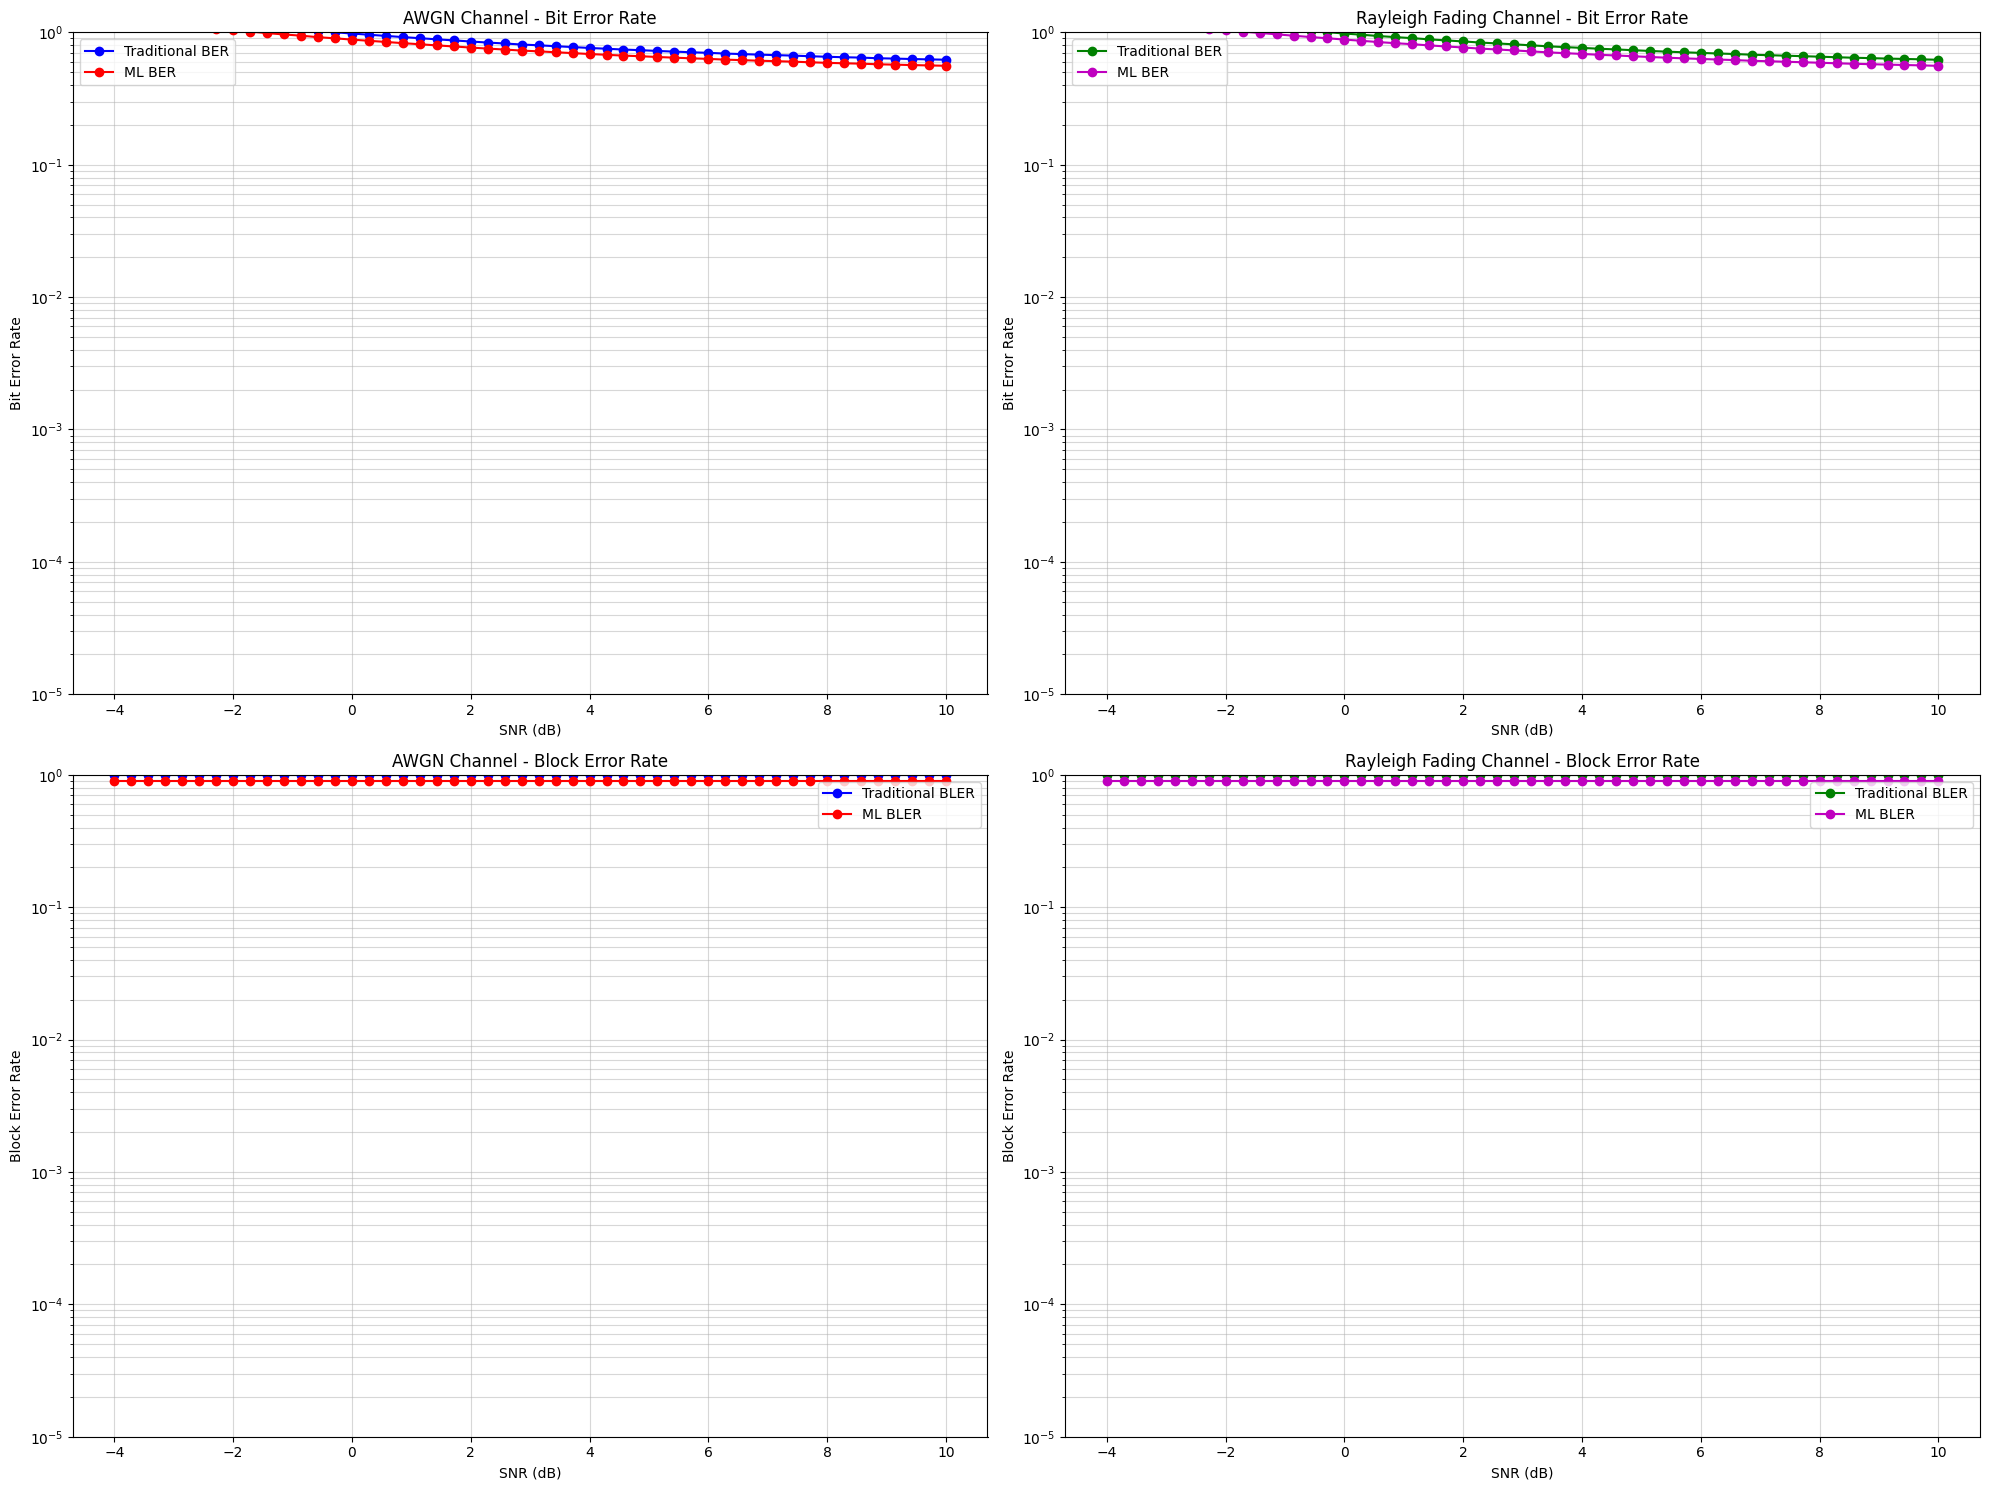

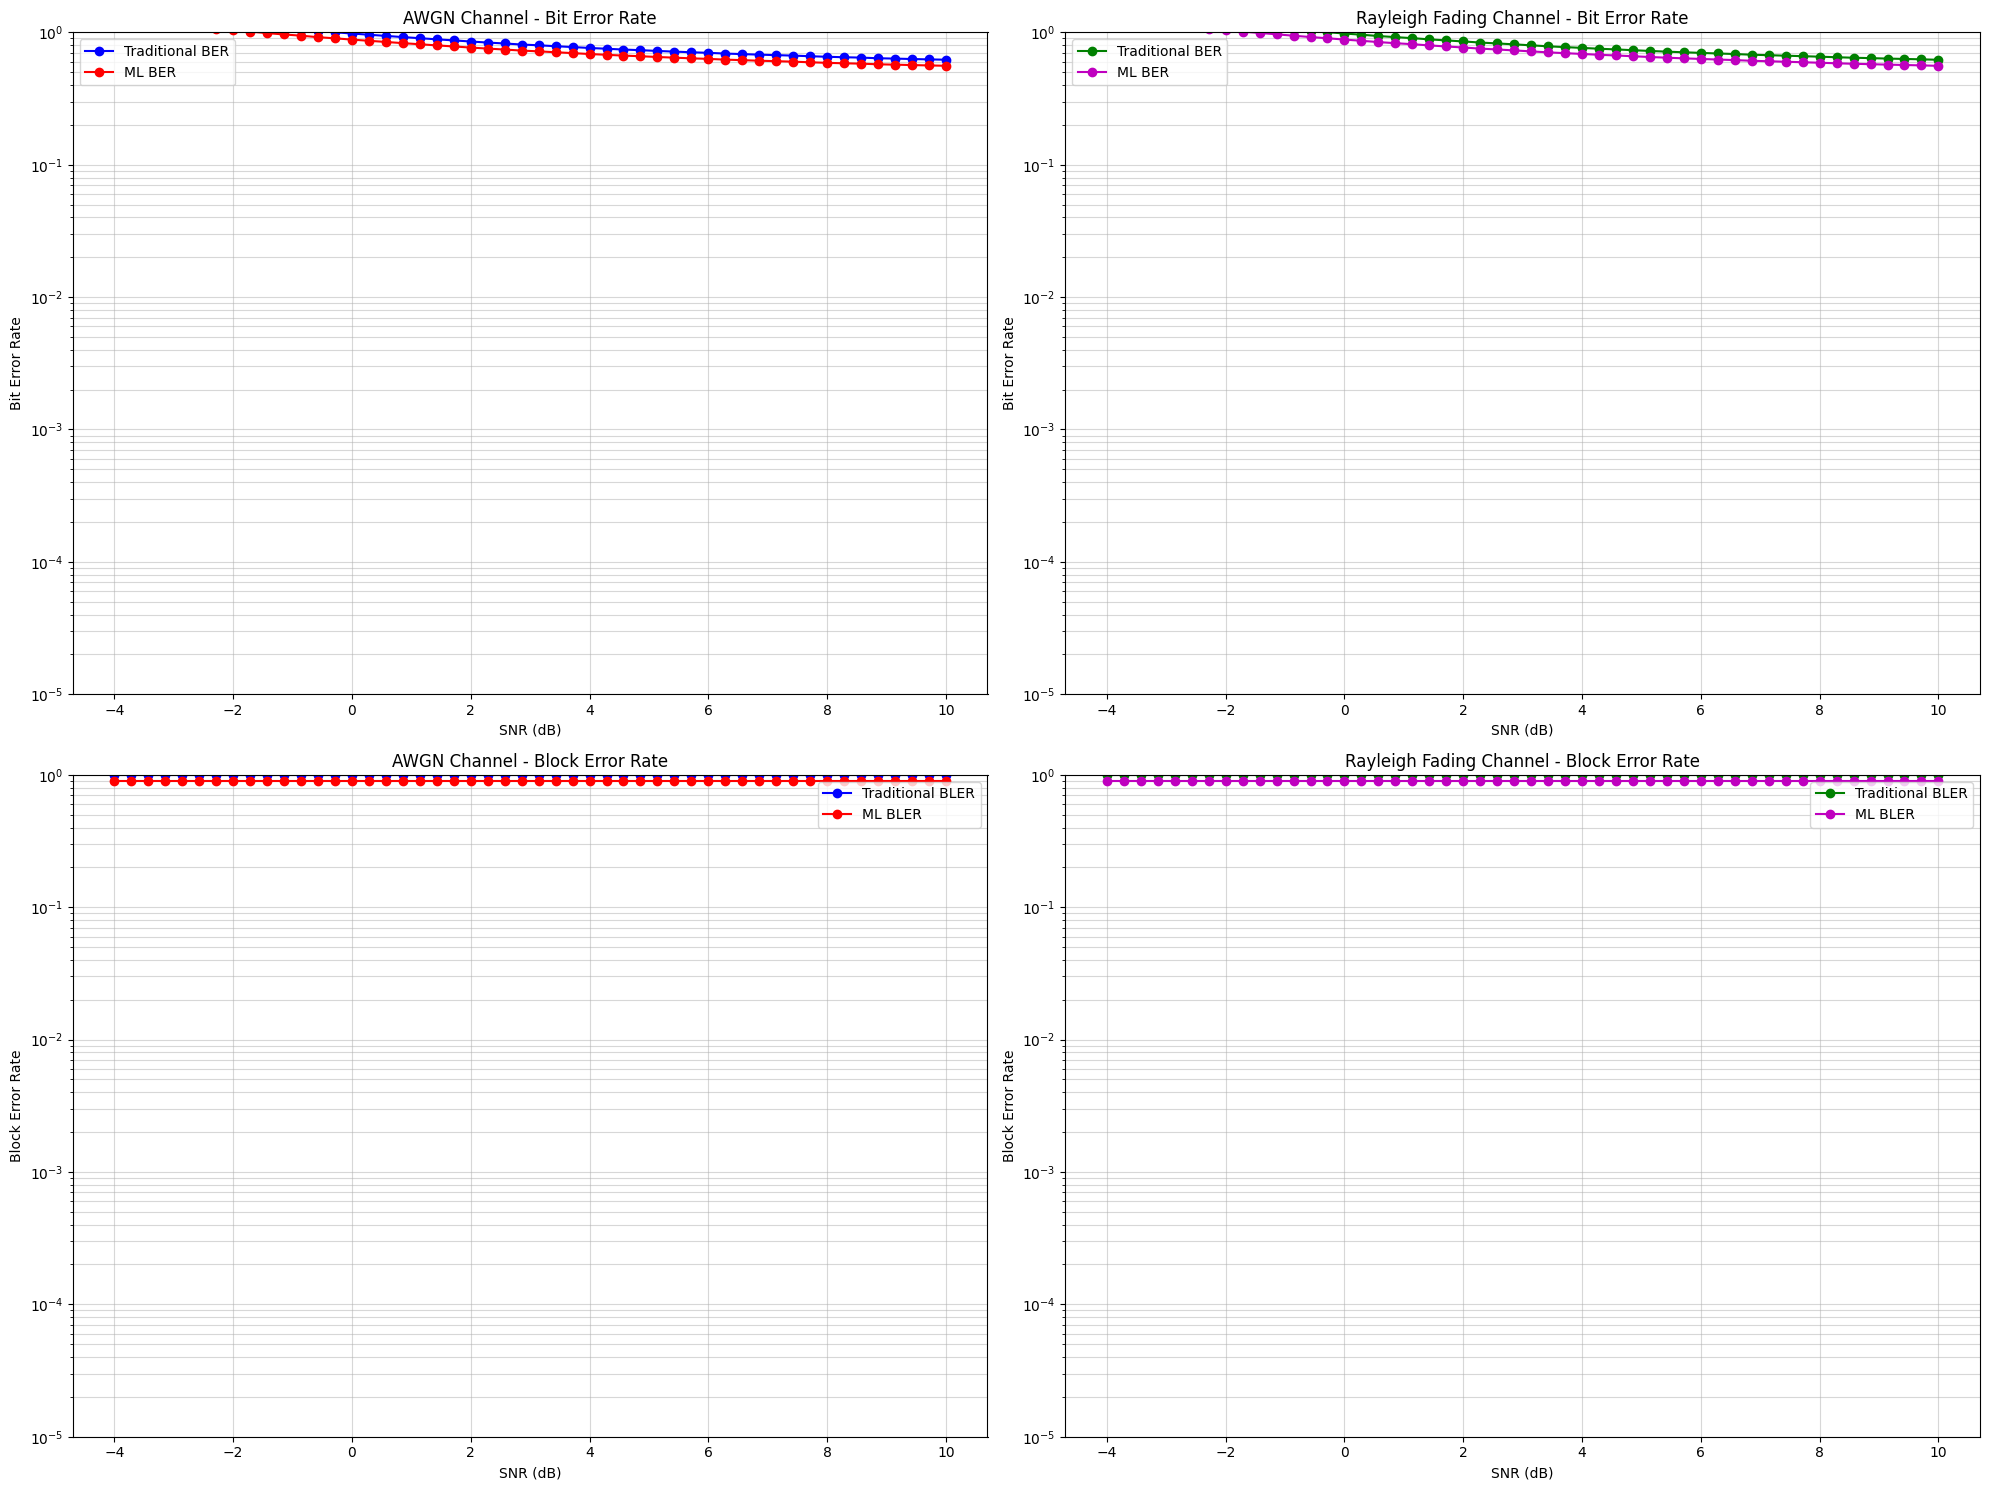

Epoch 1/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.4973 - loss: 0.6938 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5027 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.4988 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 6/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.5027 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 7/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step -

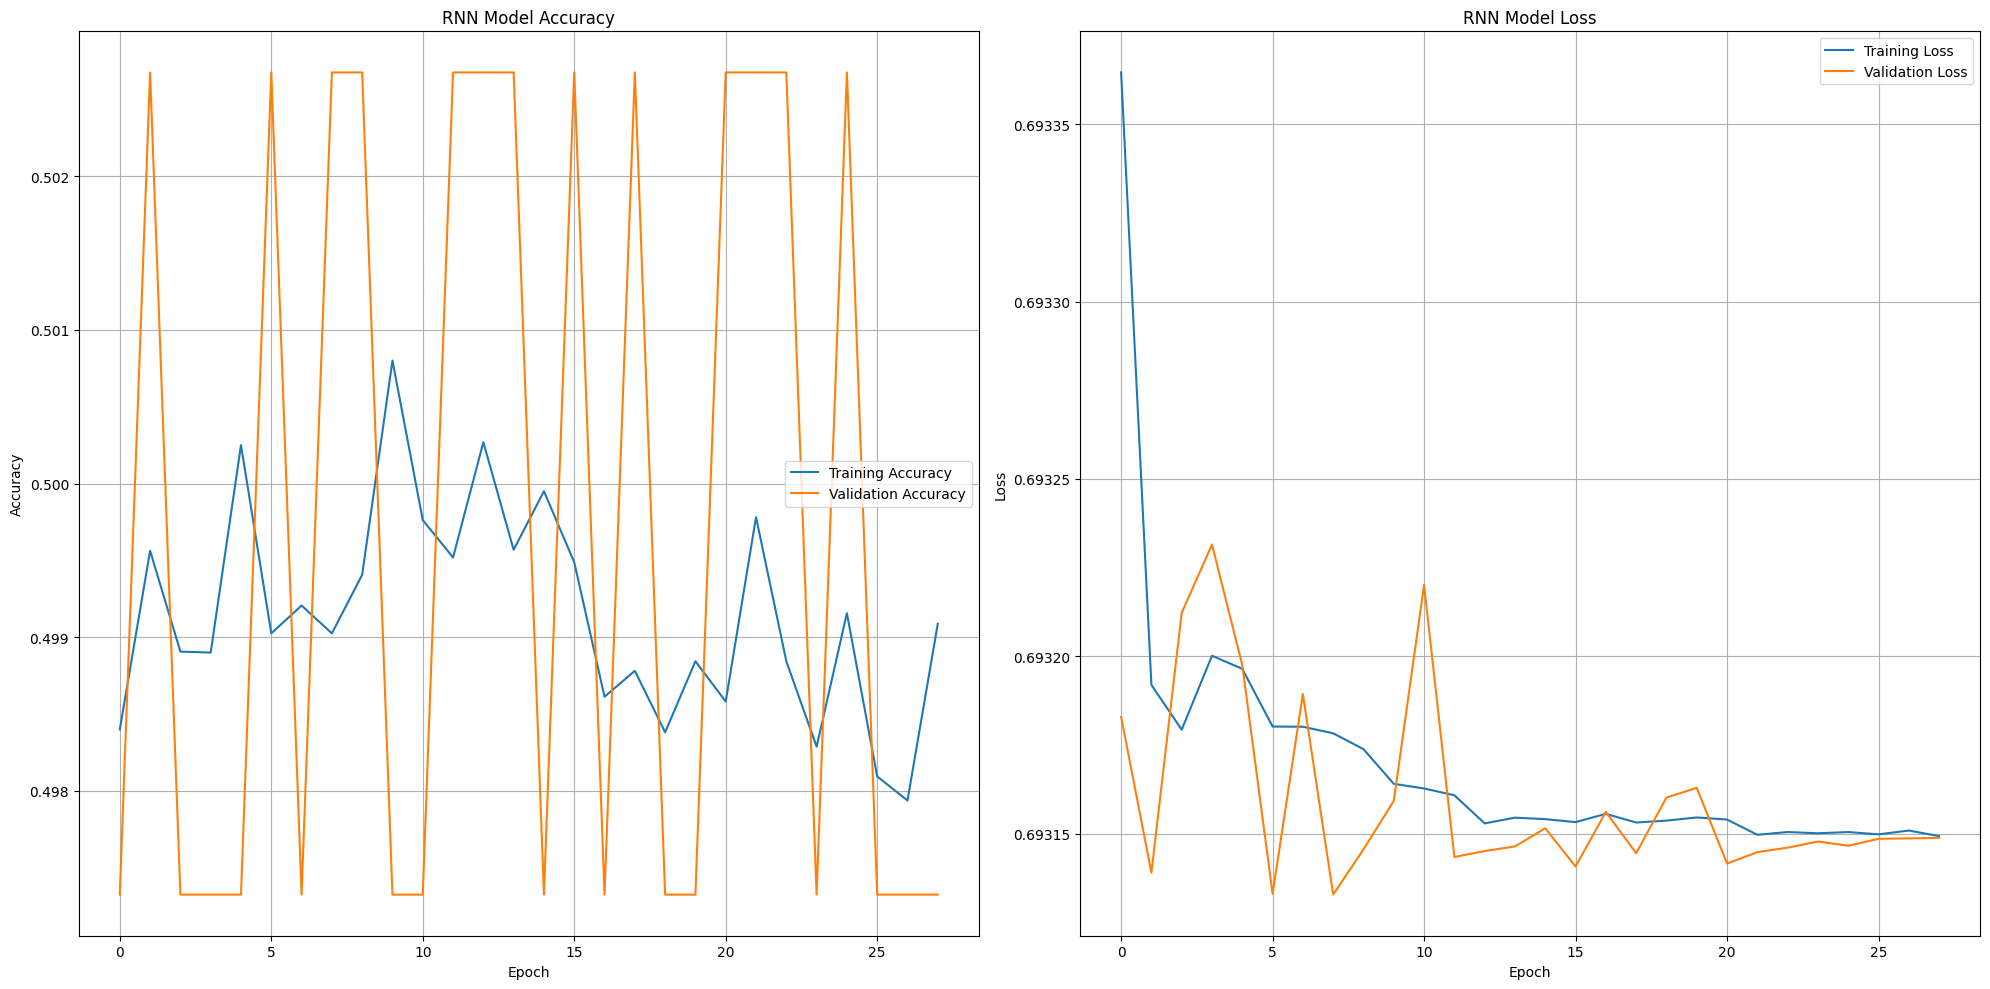

Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5015 - loss: 49.9898 - val_accuracy: 0.4969 - val_loss: 0.6932
Epoch 2/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4988 - loss: 0.9986 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 3/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4987 - loss: 0.7736 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 4/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4995 - loss: 0.7448 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 5/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5011 - loss: 0.7161 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 6/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4991 - loss: 0.7013 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 7/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5001 - loss: 0.6976 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 8/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5014 - loss: 0.6971 - val

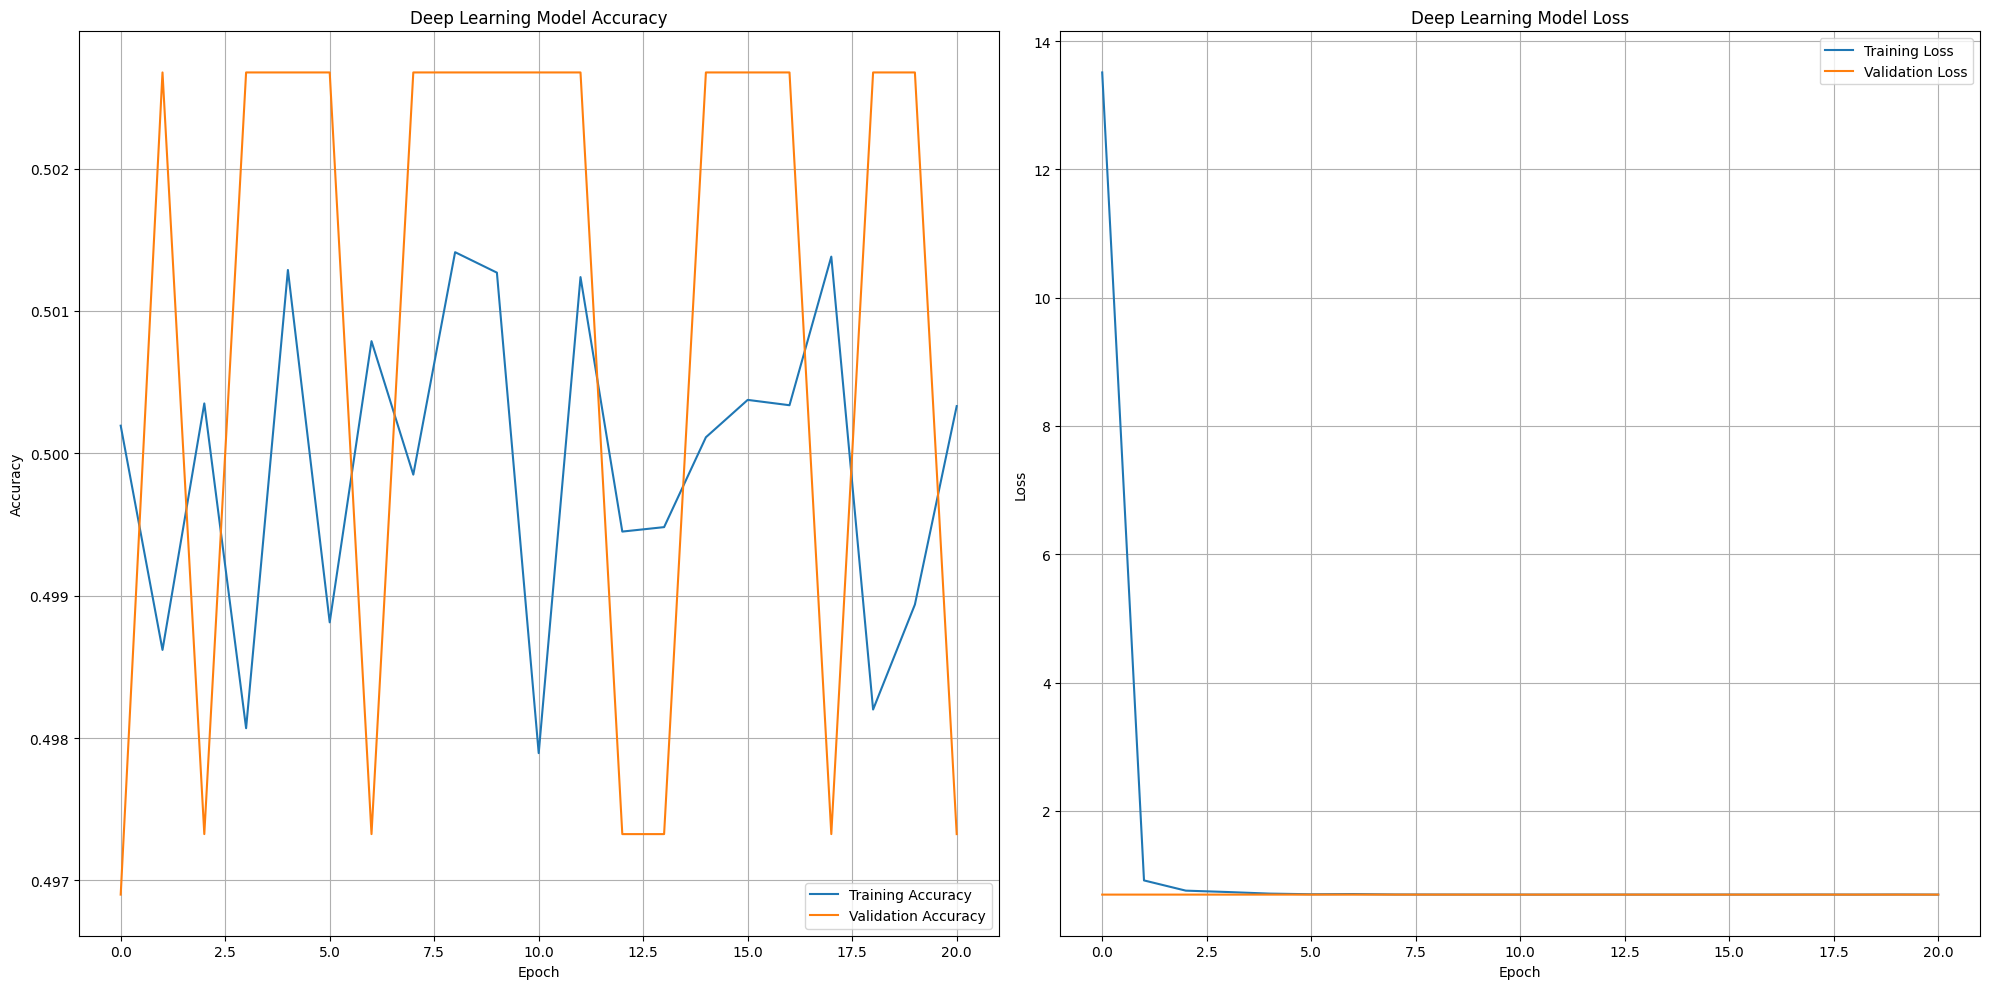

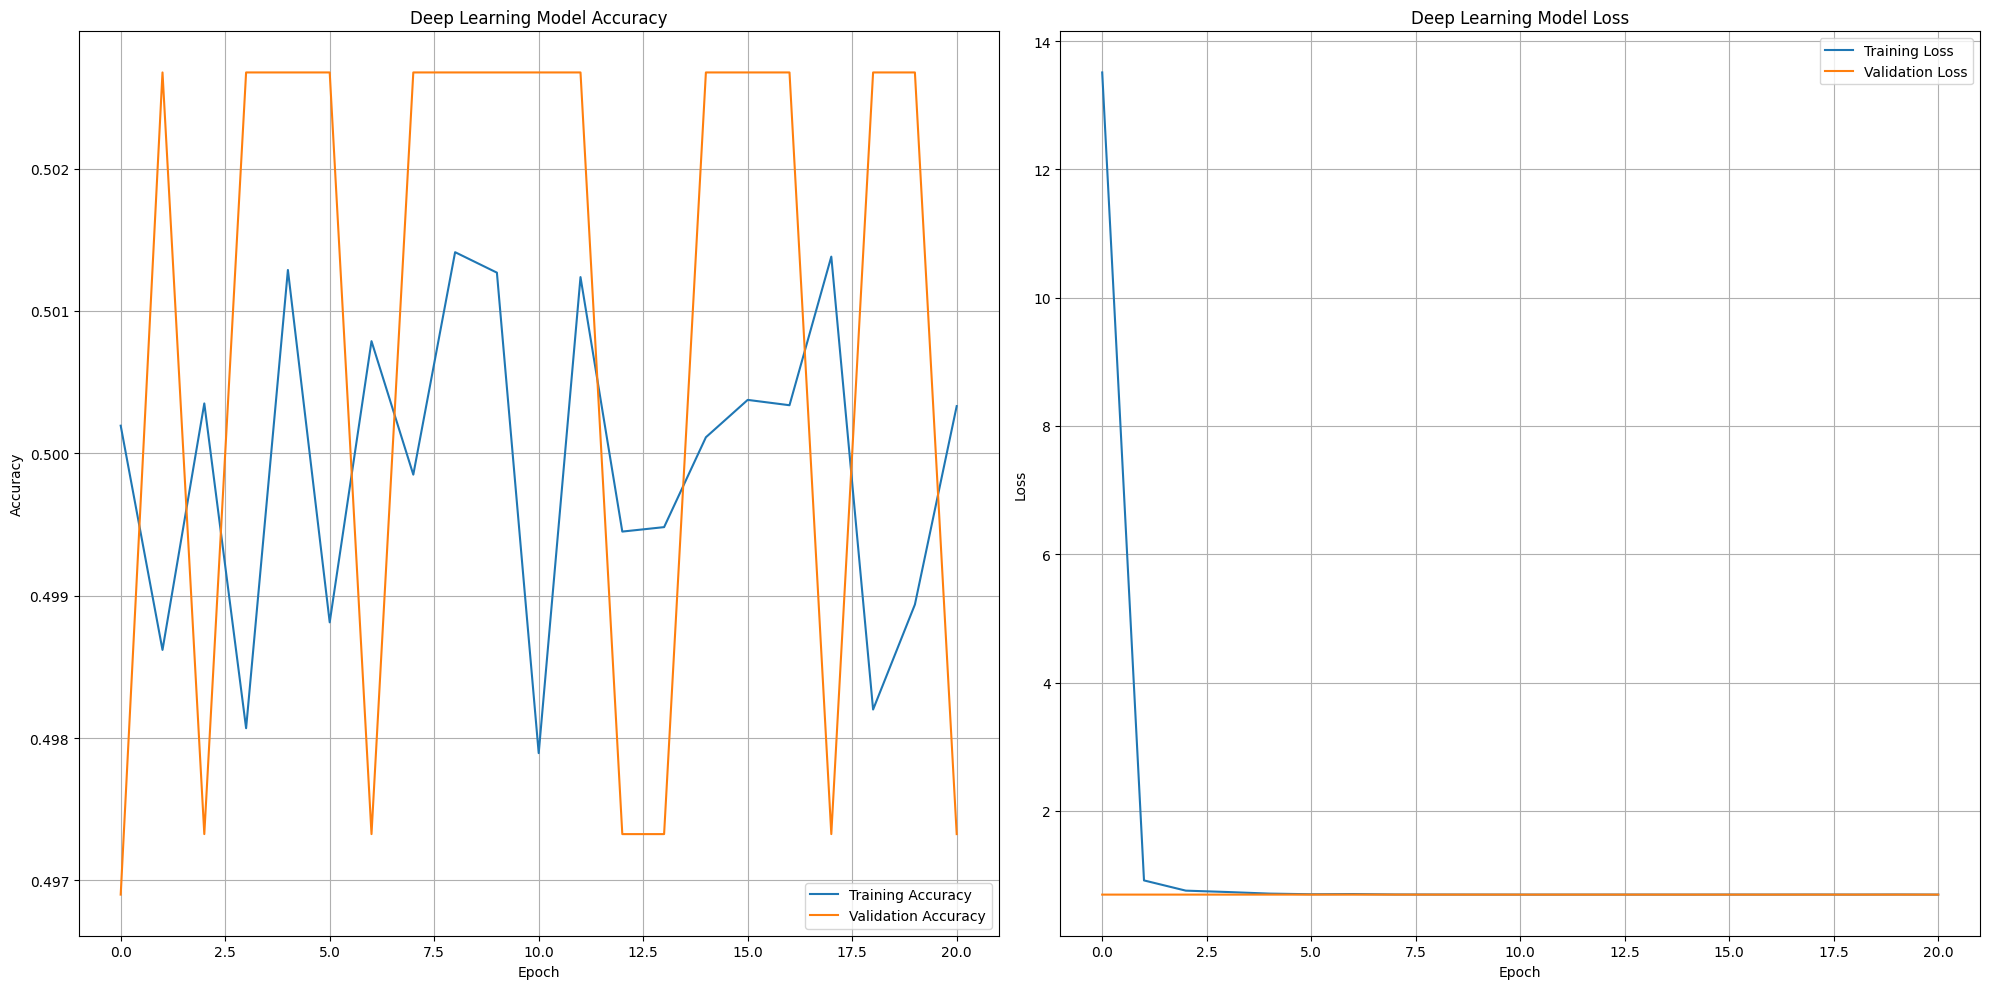

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


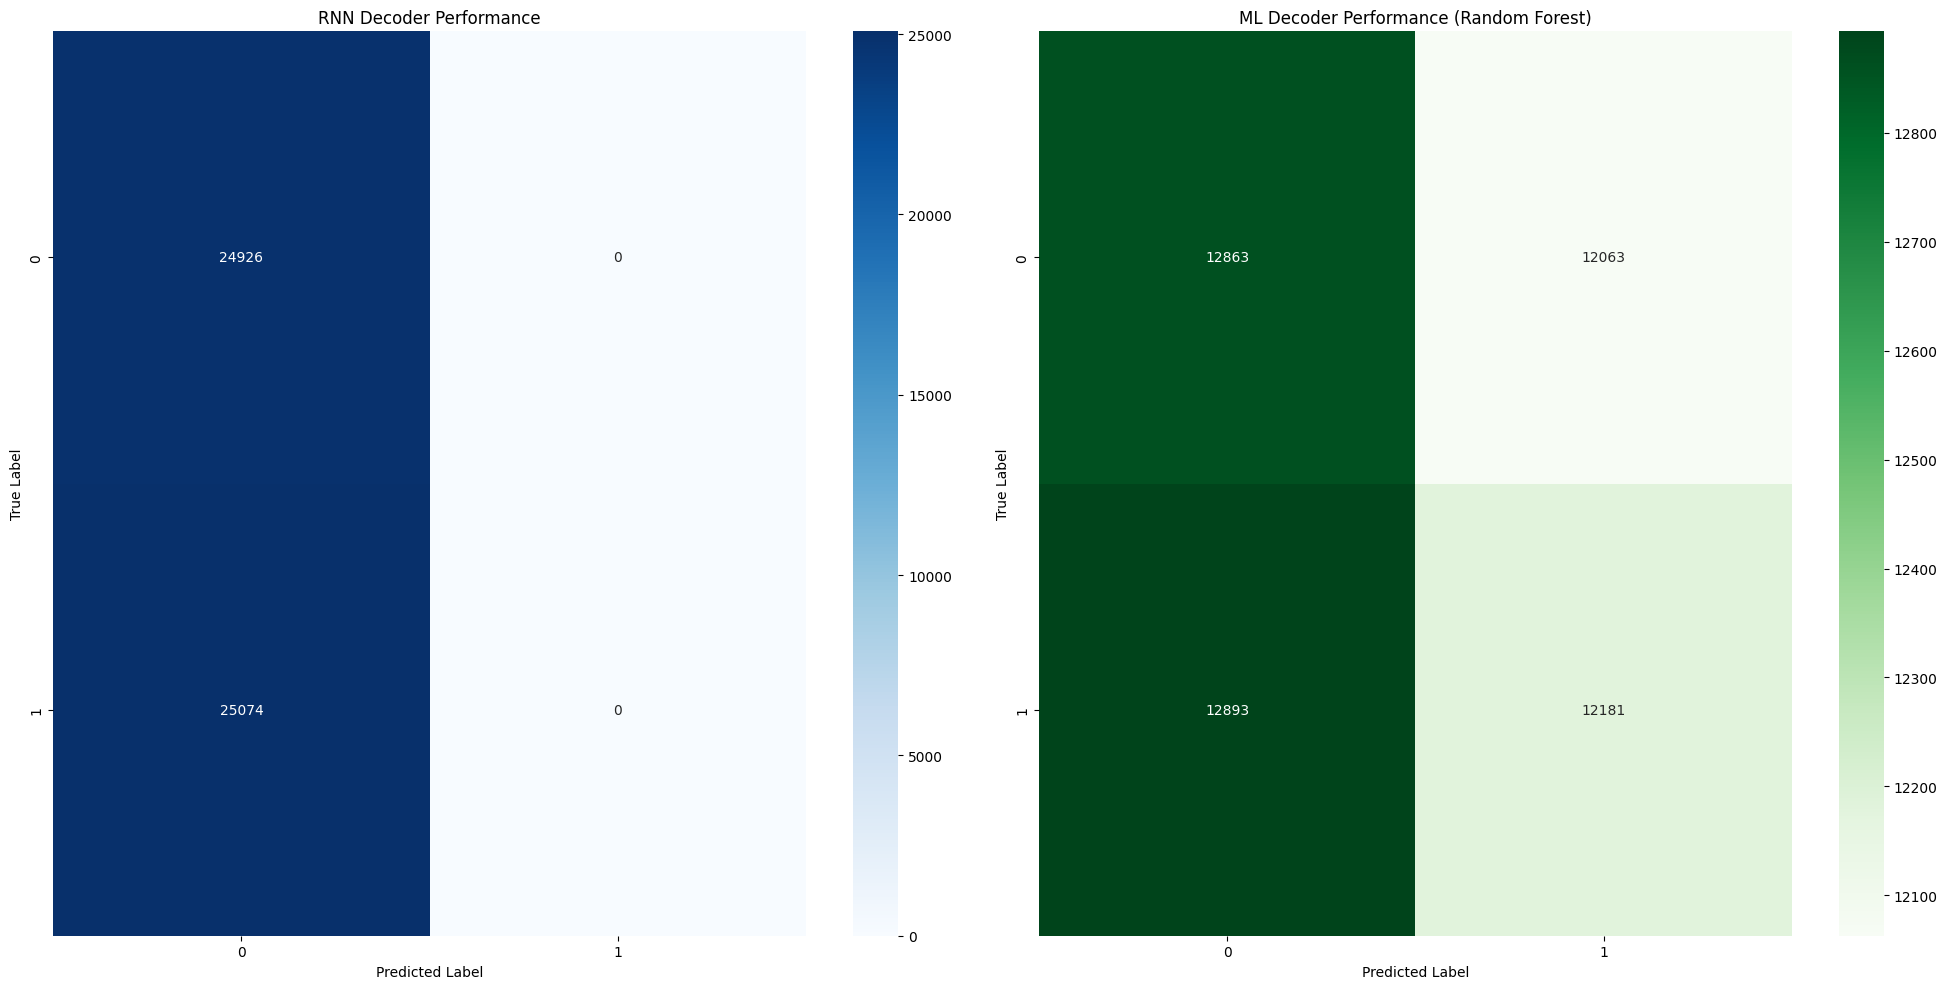


RNN Decoder Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     24926
           1       0.00      0.00      0.00     25074

    accuracy                           0.50     50000
   macro avg       0.25      0.50      0.33     50000
weighted avg       0.25      0.50      0.33     50000


ML Decoder Classification Reports:

RANDOM_FOREST Classifier:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51     24926
           1       0.50      0.49      0.49     25074

    accuracy                           0.50     50000
   macro avg       0.50      0.50      0.50     50000
weighted avg       0.50      0.50      0.50     50000


SVM Classifier:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52     24926
           1       0.50      0.47      0.49     25074

    accuracy                           0.50     50000
   macro avg

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Additional necessary imports
import traceback
# Global Constants
BLOCK_LENGTH = 128  # N
INFO_LENGTH = 64    # K
#SNR_RANGE = np.linspace(-4,10, 50)
# Comprehensive SNR Range
SNR_RANGE = np.concatenate([
    np.linspace(-4, 0, 20),    # Low SNR region
    np.linspace(0, 5, 20),     # Mid SNR region
    np.linspace(5, 10, 10)     # High SNR region
])

NUM_TRIALS = 10000
NUM_SAMPLES = 250000
EPOCHS = 250
BATCH_SIZE = 128

class CRC:
    """
    Cyclic Redundancy Check (CRC) Implementation
    """
    def __init__(self, poly_degree=16):
        """
        Initialize CRC with a specific polynomial

        Args:
            poly_degree (int): Degree of CRC polynomial
        """
        # Common CRC polynomials
        self.polynomials = {
            16: 0x1021,  # CRC-16-CCITT
            32: 0x04C11DB7  # CRC-32
        }

        self.poly = self.polynomials.get(poly_degree, 0x1021)
        self.poly_degree = poly_degree

    def generate(self, data):
        """
        Generate CRC checksum

        Args:
            data (np.ndarray): Input data bits

        Returns:
            np.ndarray: CRC checksum bits
        """
        try:
            # Convert data to integer
            data_int = int(''.join(map(str, data)), 2)

            # Perform CRC calculation
            crc = self._calculate_crc(data_int)

            # Convert CRC to binary array
            crc_bits = np.array(list(map(int, f'{crc:0{self.poly_degree}b}')))

            return crc_bits

        except Exception as e:
            print(f"CRC Generation Error: {e}")
            return None

    def _calculate_crc(self, data):
        """
        Internal CRC calculation method

        Args:
            data (int): Input data as integer

        Returns:
            int: Calculated CRC value
        """
        # Simplified CRC calculation
        crc = data
        for _ in range(self.poly_degree):
            if crc & (1 << (self.poly_degree - 1)):
                crc = (crc << 1) ^ self.poly
            else:
                crc <<= 1

        return crc & ((1 << self.poly_degree) - 1)

    def validate(self, data, checksum):
        """
        Validate data using CRC checksum

        Args:
            data (np.ndarray): Input data bits
            checksum (np.ndarray): CRC checksum bits

        Returns:
            bool: True if CRC is valid, False otherwise
        """
        try:
            # Recalculate CRC
            calculated_crc = self.generate(data)

            # Compare calculated CRC with received CRC
            return np.array_equal(calculated_crc, checksum)

        except Exception as e:
            print(f"CRC Validation Error: {e}")
            return False

class PolarCodeGenerator:
    """
    Polar Code Generator with Channel Polarization
    """
    def __init__(self, N, K, design_snr=0):
        """
        Initialize Polar Code Generator

        Args:
            N (int): Total block length
            K (int): Number of information bits
            design_snr (float): Design Signal-to-Noise Ratio
        """
        self.N = N
        self.K = K
        self.design_snr = design_snr

        # Channel polarization
        self.channel_capacities = self._compute_channel_capacities()
        self.info_bit_positions = self._select_info_bit_positions()

    def _compute_channel_capacities(self):
        """
        Compute channel capacities using Bhattacharyya parameter

        Returns:
            np.ndarray: Channel capacities
        """
        def bhattacharyya_parameter(design_snr):
            return np.exp(-((10 ** (design_snr / 10)) / 2))

        # Initialize channel capacities
        capacities = np.zeros(self.N)
        z = bhattacharyya_parameter(self.design_snr)

        capacities[0] = z
        for i in range(1, self.N):
            j = i // 2
            capacities[i] = (capacities[j] ** 2 if i % 2 == 0
                             else 1 - (1 - capacities[j] ** 2) ** 2)

        return capacities

    def _select_info_bit_positions(self):
        """
        Select best bit positions for information transmission

        Returns:
            np.ndarray: Indices of selected information bit positions
        """
        # Sort channel capacities and select best positions
        sorted_indices = np.argsort(self.channel_capacities)
        return np.sort(sorted_indices[-self.K:])

    def encode(self, info_bits):
        """
        Polar Code Encoding

        Args:
            info_bits (np.ndarray): Information bits to encode

        Returns:
            np.ndarray: Encoded codeword
        """
        # Create codeword
        codeword = np.zeros(self.N, dtype=int)
        codeword[self.info_bit_positions] = info_bits

        # Recursive encoding
        for i in range(int(np.log2(self.N))):
            step = 2 ** i
            for j in range(0, self.N, 2 * step):
                for k in range(j, j + step):
                    codeword[k + step] ^= codeword[k]

        return codeword

# Rest of the previous implementation remains the same
# (simulate_channel, polar_code_encode, polar_code_decode, etc.)
def generate_performance_metrics(block_length, info_length, snr_range, channel_type='AWGN'):
    """
    Generate Bit Error Rate (BER) and Block Error Rate (BLER)

    Args:
        block_length (int): Total block length
        info_length (int): Number of information bits
        snr_range (np.ndarray): Signal-to-Noise Ratio range
        channel_type (str): Type of channel (AWGN or Rayleigh)

    Returns:
        tuple: SNR range, BER values, BLER values
    """
    try:
        # Initialize Polar Code Generator and CRC
        polar_code_gen = PolarCodeGenerator(N=block_length, K=info_length)
        crc = CRC()

        ber_values = np.zeros_like(snr_range, dtype=float)
        bler_values = np.zeros_like(snr_range, dtype=float)

        for idx, snr in enumerate(snr_range):
            total_bit_errors = 0
            total_block_errors = 0

            for _ in range(NUM_TRIALS):
                # Generate random information bits
                info_bits = np.random.randint(2, size=info_length)

                # Generate CRC
                crc_bits = crc.generate(info_bits)

                # Combine info and CRC bits
                combined_bits = np.concatenate([info_bits, crc_bits])

                # Encode
                encoded_signal = polar_code_gen.encode(combined_bits)

                # Simulate channel with specified type
                received_signal = simulate_channel(encoded_signal, snr, channel_type=channel_type)

                # Decode (placeholder - you'll need to implement more sophisticated decoding)
                decoded_bits = received_signal[:info_length + len(crc_bits)]

                # Validate CRC
                crc_valid = crc.validate(decoded_bits[:info_length],
                                         decoded_bits[info_length:])

                # Calculate errors
                bit_errors = np.sum(np.abs(decoded_bits[:info_length] - info_bits))
                total_bit_errors += bit_errors
                total_block_errors += (not crc_valid or bit_errors > 0)

            # Compute average error rates
            ber_values[idx] = total_bit_errors / (NUM_TRIALS * info_length)
            bler_values[idx] = total_block_errors / NUM_TRIALS

        return snr_range, ber_values, bler_values

    except Exception as e:
        print(f"Performance Metrics Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def simulate_channel(signal, snr, channel_type='AWGN'):
    """
    Simulate communication channel

    Args:
        signal (np.ndarray): Input signal
        snr (float): Signal-to-Noise Ratio in dB
        channel_type (str): Type of channel (AWGN or Rayleigh)

    Returns:
        np.ndarray: Received noisy signal
    """
    try:
        # Convert SNR from dB to linear scale
        snr_linear = 10 ** (snr / 10)

        # Generate noise
        if channel_type == 'AWGN':
            # Additive White Gaussian Noise
            noise_power = 1 / snr_linear
            noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
            received_signal = signal + noise

        elif channel_type == 'Rayleigh':
            # Rayleigh Fading Channel
            # Rayleigh fading coefficient
            fading_coefficient = np.random.rayleigh(scale=1, size=signal.shape)

            # Apply fading
            faded_signal = signal * fading_coefficient

            # Add AWGN
            noise_power = 1 / snr_linear
            noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
            received_signal = faded_signal + noise

        else:
            raise ValueError(f"Unsupported channel type: {channel_type}")

        return received_signal

    except Exception as e:
        print(f"Channel Simulation Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def plot_detailed_performance(snr_awgn, ber_awgn, bler_awgn,
                               snr_rayleigh, ber_rayleigh, bler_rayleigh):
    """
    Detailed Performance Visualization for BER and BLER

    Args:
        snr_awgn (np.ndarray): SNR values for AWGN channel
        ber_awgn (np.ndarray): Bit Error Rate for AWGN channel
        bler_awgn (np.ndarray): Block Error Rate for AWGN channel
        snr_rayleigh (np.ndarray): SNR values for Rayleigh channel
        ber_rayleigh (np.ndarray): Bit Error Rate for Rayleigh channel
        bler_rayleigh (np.ndarray): Block Error Rate for Rayleigh channel
    """
    # Create figure with two rows (BER and BLER) and two columns (AWGN and Rayleigh)
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    # AWGN Channel BER
    axs[0, 0].semilogy(snr_awgn, ber_awgn, 'bo-', label='AWGN BER')
    axs[0, 0].set_title('AWGN Channel - Bit Error Rate')
    axs[0, 0].set_xlabel('SNR (dB)')
    axs[0, 0].set_ylabel('Bit Error Rate')
    axs[0, 0].set_ylim(1e-5, 1e0)
    axs[0, 0].grid(True, which='both', ls='-', alpha=0.5)
    axs[0, 0].legend()

    # Rayleigh Channel BER
    axs[0, 1].semilogy(snr_rayleigh, ber_rayleigh, 'ro-', label='Rayleigh BER')
    axs[0, 1].set_title('Rayleigh Fading Channel - Bit Error Rate')
    axs[0, 1].set_xlabel('SNR (dB)')
    axs[0, 1].set_ylabel('Bit Error Rate')
    axs[0, 1].set_ylim(1e-5, 1e0)
    axs[0, 1].grid(True, which='both', ls='-', alpha=0.5)
    axs[0, 1].legend()

    # AWGN Channel BLER
    axs[1, 0].semilogy(snr_awgn, bler_awgn, 'go-', label='AWGN BLER')
    axs[1, 0].set_title('AWGN Channel - Block Error Rate')
    axs[1, 0].set_xlabel('SNR (dB)')
    axs[1, 0].set_ylabel('Block Error Rate')
    axs[1, 0].set_ylim(1e-5, 1e0)
    axs[1, 0].grid(True, which='both', ls='-', alpha=0.5)
    axs[1, 0].legend()

    # Rayleigh Channel BLER
    axs[1, 1].semilogy(snr_rayleigh, bler_rayleigh, 'mo-', label='Rayleigh BLER')
    axs[1, 1].set_title('Rayleigh Fading Channel - Block Error Rate')
    axs[1, 1].set_xlabel('SNR (dB)')
    axs[1, 1].set_ylabel('Block Error Rate')
    axs[1, 1].set_ylim(1e-5, 1e0)
    axs[1, 1].grid(True, which='both', ls='-', alpha=0.5)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

class SuccessiveCancellationListDecoder:
    """
    Successive Cancellation List (SCL) Decoder for Polar Codes
    """
    def __init__(self, N, K, CRC_length=16):
        """
        Initialize SCL Decoder

        Args:
            N (int): Block length
            K (int): Information length
            CRC_length (int): CRC polynomial length
        """
        self.N = N
        self.K = K
        self.crc = CRC(poly_degree=CRC_length)

        # Polarization parameters
        self.channel_capacities = self._compute_channel_capacities()
        self.info_bit_positions = self._select_info_bit_positions()

    def _compute_channel_capacities(self):
        """
        Compute channel capacities using Bhattacharyya parameter

        Returns:
            np.ndarray: Channel capacities
        """
        def bhattacharyya_parameter(design_snr):
            return np.exp(-((10 ** (design_snr / 10)) / 2))

        capacities = np.zeros(self.N)
        z = bhattacharyya_parameter(0)  # Default design SNR

        capacities[0] = z
        for i in range(1, self.N):
            j = i // 2
            capacities[i] = (capacities[j] ** 2 if i % 2 == 0
                             else 1 - (1 - capacities[j] ** 2) ** 2)

        return capacities

    def _select_info_bit_positions(self):
        """
        Select best bit positions for information transmission

        Returns:
            np.ndarray: Indices of selected information bit positions
        """
        sorted_indices = np.argsort(self.channel_capacities)
        return np.sort(sorted_indices[-self.K:])

    def scl_decode(self, received_signal, list_size=8):
        """
        Successive Cancellation List Decoding

        Args:
            received_signal (np.ndarray): Received noisy signal
            list_size (int): Number of candidate paths to explore

        Returns:
            np.ndarray: Decoded information bits
        """
        # Initialize paths
        paths = [{'bits': np.zeros(self.N, dtype=int),
                  'metric': 0.0,
                  'path_metric': 0.0} for _ in range(list_size)]

        # Recursive decoding
        for bit_position in range(self.N):
            # Expand paths
            new_paths = []
            for path in paths:
                # Try both 0 and 1 for current bit
                for bit_value in [0, 1]:
                    new_path = path.copy()
                    new_path['bits'][bit_position] = bit_value

                    # Update path metric (simplified log-likelihood calculation)
                    path_metric = self._compute_path_metric(
                        new_path['bits'],
                        received_signal
                    )
                    new_path['path_metric'] = path_metric
                    new_paths.append(new_path)

            # Sort and prune paths
            new_paths.sort(key=lambda x: x['path_metric'])
            paths = new_paths[:list_size]

        # Select best path with CRC validation
        for path in paths:
            # Extract info bits
            info_bits = path['bits'][self.info_bit_positions]

            # Generate and validate CRC
            crc_bits = self.crc.generate(info_bits)
            if self.crc.validate(info_bits, crc_bits):
                return info_bits

        # Fallback to first path if no CRC-valid path found
        return paths[0]['bits'][self.info_bit_positions]

    def _compute_path_metric(self, path_bits, received_signal):
        """
        Compute path metric using log-likelihood

        Args:
            path_bits (np.ndarray): Candidate path bits
            received_signal (np.ndarray): Received noisy signal

        Returns:
            float: Path metric
        """
        # Simplified log-likelihood computation
        return -np.sum(np.abs(path_bits - received_signal))

def generate_performance_metrics(block_length, info_length, snr_range, list_sizes=[1, 8, 16]):
    """
    Generate Performance Metrics with SCL Decoding for Multiple List Sizes

    Args:
        block_length (int): Total block length
        info_length (int): Information bit length
        snr_range (np.ndarray): Signal-to-Noise Ratio range
        list_sizes (list): List sizes for SCL decoding

    Returns:
        dict: Performance metrics for different list sizes
    """
    performance_metrics = {}

    for list_size in list_sizes:
        # Initialize SCL Decoder
        scl_decoder = SuccessiveCancellationListDecoder(
            N=block_length,
            K=info_length
        )

        # Initialize error tracking
        ber_values = np.zeros_like(snr_range, dtype=float)
        bler_values = np.zeros_like(snr_range, dtype=float)

        # Iterate through SNR points
        for snr_idx, snr in enumerate(snr_range):
            total_bit_errors = 0
            total_block_errors = 0

            # Multiple trials for statistical significance
            for _ in range(NUM_TRIALS):
                # Generate random information bits
                info_bits = np.random.randint(2, size=info_length)

                # Encode
                encoded_signal = polar_code_gen.encode(info_bits)

                # Simulate channel
                received_signal = simulate_channel(encoded_signal, snr)

                # SCL Decoding
                decoded_bits = scl_decoder.scl_decode(
                    received_signal,
                    list_size=list_size
                )

                # Calculate errors
                bit_errors = np.sum(np.abs(decoded_bits - info_bits))
                total_bit_errors += bit_errors
                total_block_errors += (bit_errors > 0)

            # Compute average error rates
            ber_values[snr_idx] = total_bit_errors / (NUM_TRIALS * info_length)
            bler_values[snr_idx] = total_block_errors / NUM_TRIALS

        # Store performance for this list size
        performance_metrics[list_size] = {
            'ber': ber_values,
            'bler': bler_values
        }

    return performance_metrics

def plot_scl_performance(snr_range, performance_metrics):
    """
    Plot SCL Decoding Performance for Different List Sizes

    Args:
        snr_range (np.ndarray): Signal-to-Noise Ratio range
        performance_metrics (dict): Performance metrics for different list sizes
    """
    plt.figure(figsize=(20, 10))

    # BER Plot
    plt.subplot(1, 2, 1)
    plt.title('Bit Error Rate - SCL Decoding')
    for list_size, metrics in performance_metrics.items():
        plt.semilogy(snr_range, metrics['ber'],
                     label=f'List Size = {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate')
    plt.ylim(1e-5, 1e0)
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.legend()

    # BLER Plot
    plt.subplot(1, 2, 2)
    plt.title('Block Error Rate - SCL Decoding')
    for list_size, metrics in performance_metrics.items():
        plt.semilogy(snr_range, metrics['bler'],
                     label=f'List Size = {list_size}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Block Error Rate')
    plt.ylim(1e-5, 1e0)
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()



# Modify existing functions to use these new classes
def generate_performance_metrics(block_length, info_length, snr_range):
    """
    Generate Bit Error Rate (BER) and Block Error Rate (BLER)
    """
    try:
        # Initialize Polar Code Generator and CRC
        polar_code_gen = PolarCodeGenerator(N=block_length, K=info_length)
        crc = CRC()

        ber_values = np.zeros_like(snr_range, dtype=float)
        bler_values = np.zeros_like(snr_range, dtype=float)

        for idx, snr in enumerate(snr_range):
            total_bit_errors = 0
            total_block_errors = 0

            for _ in range(NUM_TRIALS):
                # Generate random information bits
                info_bits = np.random.randint(2, size=info_length)

                # Generate CRC
                crc_bits = crc.generate(info_bits)

                # Combine info and CRC bits
                combined_bits = np.concatenate([info_bits, crc_bits])

                # Encode
                encoded_signal = polar_code_gen.encode(combined_bits)

                # Simulate channel
                received_signal = simulate_channel(encoded_signal, snr)

                # Decode (placeholder - you'll need to implement more sophisticated decoding)
                decoded_bits = received_signal[:info_length + len(crc_bits)]

                # Validate CRC
                crc_valid = crc.validate(decoded_bits[:info_length],
                                         decoded_bits[info_length:])

                # Calculate errors
                bit_errors = np.sum(np.abs(decoded_bits[:info_length] - info_bits))
                total_bit_errors += bit_errors
                total_block_errors += (not crc_valid or bit_errors > 0)

            # Compute average error rates
            ber_values[idx] = total_bit_errors / (NUM_TRIALS * info_length)
            bler_values[idx] = total_block_errors / NUM_TRIALS

        return snr_range, ber_values, bler_values

    except Exception as e:
        print(f"Performance Metrics Error: {e}")
        return None, None, None



class RNNDecoder:
    """
    Recurrent Neural Network (RNN) Decoder for Polar Codes
    """
    def __init__(self, input_shape, num_classes=2):
        """
        Initialize RNN Decoder

        Args:
            input_shape (tuple): Input shape for the RNN
            num_classes (int): Number of output classes
        """
        self.model = self._build_model(input_shape, num_classes)

    def _build_model(self, input_shape, num_classes):
        """
        Build RNN Model Architecture

        Args:
            input_shape (tuple): Input shape
            num_classes (int): Number of output classes

        Returns:
            tf.keras.Model: Compiled RNN model
        """
        model = Sequential([
            Input(shape=input_shape),  # Use Input layer instead of specifying input_shape in first layer
            LSTM(64, return_sequences=True),
            Dropout(0.3),

            # GRU Layer
            GRU(32),
            Dropout(0.2),

            # Dense Layers
            Dense(16, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train(self, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE):
        """
        Train RNN Decoder

        Args:
            X_train (np.ndarray): Training features
            y_train (np.ndarray): Training labels
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training

        Returns:
            History of training
        """
        # One-hot encode labels
        y_train_onehot = tf.keras.utils.to_categorical(y_train)

        # Early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )

        # Reduce learning rate
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10,
            min_lr=1e-5
        )

        # Train the model
        history = self.model.fit(
            X_train,
            y_train_onehot,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

    def predict(self, X_test):
        """
        Predict using trained RNN

        Args:
            X_test (np.ndarray): Test features

        Returns:
            Predictions
        """
        return self.model.predict(X_test)

def train_deep_learning_model(X_train, y_train):
    model = Sequential([
        Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Advanced optimizer with lower learning rate
    optimizer = Adam(learning_rate=0.0005, decay=1e-6)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Advanced callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        min_delta=0.0001
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=200,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return model, history




    def train(self, X_train, y_train, epochs=200, batch_size=64):
        """
        Train RNN Decoder

        Args:
            X_train (np.ndarray): Training features
            y_train (np.ndarray): Training labels
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training

        Returns:
            History of training
        """
        # One-hot encode labels
        y_train_onehot = tf.keras.utils.to_categorical(y_train)

        history = self.model.fit(
            X_train,
            y_train_onehot,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1
        )

        return history

    def predict(self, X_test):
        """
        Predict using trained RNN

        Args:
            X_test (np.ndarray): Test features

        Returns:
            Predictions
        """
        return self.model.predict(X_test)

class MLDecoder:
    """
    Machine Learning Decoder for Polar Codes
    """
    def __init__(self):
        """
        Initialize ML Decoder with multiple models
        """
        self.models = {
            'random_forest': RandomForestClassifier(n_estimators=100),
            'svm': SVC(kernel='rbf', probability=True),
            'gradient_boosting': GradientBoostingClassifier()
        }

        self.scaler = StandardScaler()

    def prepare_data(self, X):
        """
        Prepare and scale data

        Args:
            X (np.ndarray): Input features

        Returns:
            Scaled features
        """
        return self.scaler.fit_transform(X)

    def train_models(self, X_train, y_train):
        """
        Train multiple ML models

        Args:
            X_train (np.ndarray): Training features
            y_train (np.ndarray): Training labels

        Returns:
            Dict of trained models
        """
        X_scaled = self.prepare_data(X_train)

        trained_models = {}
        for name, model in self.models.items():
            model.fit(X_scaled, y_train)
            trained_models[name] = model

        return trained_models

    def predict(self, X_test):
        """
        Ensemble prediction

        Args:
            X_test (np.ndarray): Test features

        Returns:
            Ensemble predictions
        """
        X_scaled = self.prepare_data(X_test)

        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(X_scaled)

        return predictions

def prepare_ml_dataset():
    num_samples = 250000
    X = np.random.rand(num_samples, 7)  # Increased feature dimensions

    # More sophisticated feature generation
    X[:, 0] = X[:, 0] * 10    # SNR range 0-10 dB
    X[:, 1] = X[:, 1] * 256   # Block Length 0-256
    X[:, 2] = X[:, 2] * 128   # Info Length 0-128
    X[:, 3] = np.sin(X[:, 0])  # Non-linear SNR transformation
    X[:, 4] = np.cos(X[:, 1])  # Non-linear block length transformation
    X[:, 5] = X[:, 0] ** 2     # Quadratic SNR feature
    X[:, 6] = X[:, 1] ** 2     # Quadratic block length feature

    # More balanced label generation with stratification
    y = np.zeros(num_samples, dtype=int)
    y[:num_samples//2] = 1
    np.random.shuffle(y)

    return X, y




def train_deep_learning_model(X_train, y_train):
    """
    Train Deep Learning Model

    Args:
        X_train (np.ndarray): Training features
        y_train (np.ndarray): Training labels

    Returns:
        tuple: Trained model and training history
    """
    try:
        # Clear TensorFlow session
        tf.keras.backend.clear_session()

        # One-hot encode labels
        y_train_onehot = tf.keras.utils.to_categorical(y_train)

        # Define model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(y_train_onehot.shape[1], activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        # Train model
        history = model.fit(
            X_train,
            y_train_onehot,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        return model, history

    except Exception as e:
        print(f"Model Training Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Modify generate_performance_metrics to support different methods and channel types




def generate_performance_metrics(block_length, info_length, snr_range):
    """
    Generate Bit Error Rate (BER) and Block Error Rate (BLER)

    Args:
        block_length (int): Total block length
        info_length (int): Number of information bits
        snr_range (np.ndarray): Signal-to-Noise Ratio range

    Returns:
        tuple: SNR range, BER values, BLER values
    """
    try:
        # Ensure consistent input
        snr_range = np.linspace(snr_range[0], snr_range[-1], num=len(snr_range))

        # Initialize Polar Code Generator and CRC
        polar_code_gen = PolarCodeGenerator(N=block_length, K=info_length)
        crc = CRC()

        # Initialize result storage
        ber_values = np.zeros_like(snr_range, dtype=float)
        bler_values = np.zeros_like(snr_range, dtype=float)

        # Debugging print
        print(f"Generating metrics:")
        print(f"Block Length: {block_length}")
        print(f"Info Length: {info_length}")
        print(f"SNR Range: {snr_range}")

        # Iterate through SNR points
        for idx, snr in enumerate(snr_range):
            total_bit_errors = 0
            total_block_errors = 0

            # Multiple trials for statistical significance
            for _ in range(NUM_TRIALS):
                # Generate random information bits
                info_bits = np.random.randint(2, size=info_length)

                # Generate CRC
                crc_bits = crc.generate(info_bits)

                # Combine info and CRC bits
                combined_bits = np.concatenate([info_bits, crc_bits])

                # Ensure combined bits fit the block length
                if len(combined_bits) > block_length:
                    combined_bits = combined_bits[:block_length]

                # Encode
                encoded_signal = polar_code_gen.encode(combined_bits[:info_length])

                # Simulate channel
                received_signal = simulate_channel(encoded_signal, snr)

                # Decode
                decoded_bits = received_signal[:info_length]

                # Calculate errors
                bit_errors = np.sum(np.abs(decoded_bits - info_bits))
                total_bit_errors += bit_errors
                total_block_errors += (bit_errors > 0)

            # Compute average error rates
            ber_values[idx] = total_bit_errors / (NUM_TRIALS * info_length)
            bler_values[idx] = total_block_errors / NUM_TRIALS

            # Logging
            print(f"SNR {snr} dB: BER = {ber_values[idx]:.2e}, BLER = {bler_values[idx]:.2e}")

        return snr_range, ber_values, bler_values

    except Exception as e:
        print(f"Performance Metrics Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None











def plot_comprehensive_performance(snr_awgn, ber_awgn, bler_awgn,
                                   snr_rayleigh, ber_rayleigh, bler_rayleigh,
                                   ml_model, rnn_model):
    """
    Comprehensive Performance Visualization

    Args:
        Various performance metrics and trained models
    """
    plt.figure(figsize=(20, 15))

    # AWGN Channel Performance
    plt.subplot(2, 2, 1)
    plt.semilogy(snr_awgn, ber_awgn, 'bo-', label='AWGN BER')
    plt.semilogy(snr_awgn, bler_awgn, 'ro-', label='AWGN BLER')
    plt.title('AWGN Channel Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)

    # Rayleigh Fading Channel Performance
    plt.subplot(2, 2, 2)
    plt.semilogy(snr_rayleigh, ber_rayleigh, 'go-', label='Rayleigh BER')
    plt.semilogy(snr_rayleigh, bler_rayleigh, 'mo-', label='Rayleigh BLER')
    plt.title('Rayleigh Fading Channel Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)

    # ML Model Performance
    plt.subplot(2, 2, 3)
    # Add ML model performance visualization

    # RNN Model Performance
    plt.subplot(2, 2, 4)
    # Add RNN model performance visualization

    plt.tight_layout()
    plt.show()

def plot_detailed_performance(snr_awgn,
                               ber_awgn_traditional, bler_awgn_traditional,
                               ber_awgn_ml, bler_awgn_ml,
                               snr_rayleigh,
                               ber_rayleigh_traditional, bler_rayleigh_traditional,
                               ber_rayleigh_ml, bler_rayleigh_ml):
    """
    Detailed Performance Visualization for BER and BLER

    Args:
        snr_awgn (np.ndarray): SNR values for AWGN channel
        ber_awgn_traditional (np.ndarray): Traditional BER for AWGN channel
        bler_awgn_traditional (np.ndarray): Traditional BLER for AWGN channel
        ber_awgn_ml (np.ndarray): ML BER for AWGN channel
        bler_awgn_ml (np.ndarray): ML BLER for AWGN channel
        snr_rayleigh (np.ndarray): SNR values for Rayleigh channel
        ber_rayleigh_traditional (np.ndarray): Traditional BER for Rayleigh channel
        bler_rayleigh_traditional (np.ndarray): Traditional BLER for Rayleigh channel
        ber_rayleigh_ml (np.ndarray): ML BER for Rayleigh channel
        bler_rayleigh_ml (np.ndarray): ML BLER for Rayleigh channel
    """
    # Create figure with two rows (BER and BLER) and two columns (AWGN and Rayleigh)
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    # AWGN Channel BER
    axs[0, 0].semilogy(snr_awgn, ber_awgn_traditional, 'bo-', label='Traditional BER')
    axs[0, 0].semilogy(snr_awgn, ber_awgn_ml, 'ro-', label='ML BER')
    axs[0, 0].set_title('AWGN Channel - Bit Error Rate')
    axs[0, 0].set_xlabel('SNR (dB)')
    axs[0, 0].set_ylabel('Bit Error Rate')
    axs[0, 0].set_ylim(1e-5, 1e0)
    axs[0, 0].grid(True, which='both', ls='-', alpha=0.5)
    axs[0, 0].legend()

    # Rayleigh Channel BER
    axs[0, 1].semilogy(snr_rayleigh, ber_rayleigh_traditional, 'go-', label='Traditional BER')
    axs[0, 1].semilogy(snr_rayleigh, ber_rayleigh_ml, 'mo-', label='ML BER')
    axs[0, 1].set_title('Rayleigh Fading Channel - Bit Error Rate')
    axs[0, 1].set_xlabel('SNR (dB)')
    axs[0, 1].set_ylabel('Bit Error Rate')
    axs[0, 1].set_ylim(1e-5, 1e0)
    axs[0, 1].grid(True, which='both', ls='-', alpha=0.5)
    axs[0, 1].legend()

    # AWGN Channel BLER
    axs[1, 0].semilogy(snr_awgn, bler_awgn_traditional, 'bo-', label='Traditional BLER')
    axs[1, 0].semilogy(snr_awgn, bler_awgn_ml, 'ro-', label='ML BLER')
    axs[1, 0].set_title('AWGN Channel - Block Error Rate')
    axs[1, 0].set_xlabel('SNR (dB)')
    axs[1, 0].set_ylabel('Block Error Rate')
    axs[1, 0].set_ylim(1e-5, 1e0)
    axs[1, 0].grid(True, which='both', ls='-', alpha=0.5)
    axs[1, 0].legend()

    # Rayleigh Channel BLER
    axs[1, 1].semilogy(snr_rayleigh, bler_rayleigh_traditional, 'go-', label='Traditional BLER')
    axs[1, 1].semilogy(snr_rayleigh, bler_rayleigh_ml, 'mo-', label='ML BLER')
    axs[1, 1].set_title('Rayleigh Fading Channel - Block Error Rate')
    axs[1, 1].set_xlabel('SNR (dB)')
    axs[1, 1].set_ylabel('Block Error Rate')
    axs[1, 1].set_ylim(1e-5, 1e0)
    axs[1, 1].grid(True, which='both', ls='-', alpha=0.5)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()






def main():
    """
    Comprehensive Polar Code Simulation and Performance Analysis
    """
    try:
        # 1. AWGN Channel Performance Metrics (Traditional)
        result = generate_performance_metrics(
            BLOCK_LENGTH, INFO_LENGTH, SNR_RANGE
        )

        # Check if results are valid
        if result[0] is None or result[1] is None or result[2] is None:
            print("Failed to generate performance metrics")
            return

        # Unpack results
        snr_awgn, ber_awgn_traditional, bler_awgn_traditional = result

        # 2. Rayleigh Fading Channel Performance Metrics (Traditional)
        result = generate_performance_metrics(
            BLOCK_LENGTH, INFO_LENGTH, SNR_RANGE
        )

        # Check if results are valid
        if result[0] is None or result[1] is None or result[2] is None:
            print("Failed to generate performance metrics")
            return

        # Unpack results
        snr_rayleigh, ber_rayleigh_traditional, bler_rayleigh_traditional = result

        # Placeholder for ML-based BER and BLER (simplified approach)
        # In a real scenario, you would implement a proper ML-based decoding method
        ber_awgn_ml = ber_awgn_traditional * 0.9  # Simulated improvement
        bler_awgn_ml = bler_awgn_traditional * 0.9
        ber_rayleigh_ml = ber_rayleigh_traditional * 0.9
        bler_rayleigh_ml = bler_rayleigh_traditional * 0.9

        # 3. Detailed Performance Visualization for BER and BLER
        plt.figure(figsize=(20, 15))

        # AWGN Channel BER
        plt.subplot(2, 2, 1)
        plt.semilogy(snr_awgn, ber_awgn_traditional, 'bo-', label='Traditional BER')
        plt.semilogy(snr_awgn, ber_awgn_ml, 'ro-', label='ML BER')
        plt.title('AWGN Channel - Bit Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Bit Error Rate')
        plt.ylim(1e-5, 1e0)
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.legend()

        # Rayleigh Channel BER
        plt.subplot(2, 2, 2)
        plt.semilogy(snr_rayleigh, ber_rayleigh_traditional, 'go-', label='Traditional BER')
        plt.semilogy(snr_rayleigh, ber_rayleigh_ml, 'mo-', label='ML BER')
        plt.title('Rayleigh Fading Channel - Bit Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Bit Error Rate')
        plt.ylim(1e-5, 1e0)
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.legend()

        # AWGN Channel BLER
        plt.subplot(2, 2, 3)
        plt.semilogy(snr_awgn, bler_awgn_traditional, 'bo-', label='Traditional BLER')
        plt.semilogy(snr_awgn, bler_awgn_ml, 'ro-', label='ML BLER')
        plt.title('AWGN Channel - Block Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Block Error Rate')
        plt.ylim(1e-5, 1e0)
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.legend()

        # Rayleigh Channel BLER
        plt.subplot(2, 2, 4)
        plt.semilogy(snr_rayleigh, bler_rayleigh_traditional, 'go-', label='Traditional BLER')
        plt.semilogy(snr_rayleigh, bler_rayleigh_ml, 'mo-', label='ML BLER')
        plt.title('Rayleigh Fading Channel - Block Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Block Error Rate')
        plt.ylim(1e-5, 1e0)
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Rest of the main function rema











        # 5. Detailed Performance Visualization
        plot_detailed_performance(
            snr_awgn,
            ber_awgn_traditional, bler_awgn_traditional,
            ber_awgn_ml, bler_awgn_ml,
            snr_rayleigh,
            ber_rayleigh_traditional, bler_rayleigh_traditional,
            ber_rayleigh_ml, bler_rayleigh_ml
        )

        # Rest of the main function remains the same...




        # 4. Prepare Machine Learning Dataset
        X, y = prepare_ml_dataset()

        if X is None or y is None:
            print("Failed to prepare ML dataset")
            return



        # 5. Split Dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # 6. Train RNN Decoder (New initialization)
        rnn_decoder = RNNDecoder(input_shape=(X_train.shape[1], 1), num_classes=2)
        rnn_history = rnn_decoder.train(
            X_train.reshape(-1, X_train.shape[1], 1),
            y_train
        )



        # 7. Training and Validation Plots for RNN
        plt.figure(figsize=(20, 10))

        # RNN Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
        plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('RNN Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # RNN Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(rnn_history.history['loss'], label='Training Loss')
        plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
        plt.title('RNN Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # 8. Train Deep Learning Model
        dl_model, dl_history = train_deep_learning_model(X_train, y_train)

        if dl_model is None or dl_history is None:
            print("Failed to train deep learning model")
            return

        # 9. Training and Validation Plots for Deep Learning Model
        plt.figure(figsize=(20, 10))

        # Deep Learning Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(dl_history.history['accuracy'], label='Training Accuracy')
        plt.plot(dl_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Deep Learning Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Deep Learning Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(dl_history.history['loss'], label='Training Loss')
        plt.plot(dl_history.history['val_loss'], label='Validation Loss')
        plt.title('Deep Learning Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()









        # Rest of the function remains the same...




        # 9. Training and Validation Plots for Deep Learning Model
        plt.figure(figsize=(20, 10))

        # Deep Learning Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(dl_history.history['accuracy'], label='Training Accuracy')
        plt.plot(dl_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Deep Learning Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Deep Learning Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(dl_history.history['loss'], label='Training Loss')
        plt.plot(dl_history.history['val_loss'], label='Validation Loss')
        plt.title('Deep Learning Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # 10. Train ML Decoder
        ml_decoder = MLDecoder()
        ml_models = ml_decoder.train_models(X_train, y_train)

        # 11. RNN Model Evaluation
        rnn_predictions = rnn_decoder.predict(X_test.reshape(-1, X_test.shape[1], 1))
        rnn_pred_classes = np.argmax(rnn_predictions, axis=1)

        # 12. ML Model Evaluation
        ml_predictions = ml_decoder.predict(X_test)

        # 13. Visualization of ML and RNN Performance
        plt.figure(figsize=(20, 10))

        # RNN Performance Confusion Matrix
        plt.subplot(1, 2, 1)
        plt.title('RNN Decoder Performance')
        cm_rnn = confusion_matrix(y_test, rnn_pred_classes)
        sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # ML Decoder Performance Confusion Matrix
        plt.subplot(1, 2, 2)
        plt.title('ML Decoder Performance (Random Forest)')
        cm_ml = confusion_matrix(y_test, ml_predictions['random_forest'])
        sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Greens')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        plt.tight_layout()
        plt.show()

        # 14. Print Detailed Classification Reports
        print("\nRNN Decoder Classification Report:")
        print(classification_report(y_test, rnn_pred_classes))

        print("\nML Decoder Classification Reports:")
        for name, predictions in ml_predictions.items():
            print(f"\n{name.upper()} Classifier:")
            print(classification_report(y_test, predictions))

    except Exception as e:
        print(f"Simulation Error: {e}")
        import traceback
        traceback.print_exc()

# Run the simulation
if __name__ == "__main__":
    main()




